In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import *
import os

In [46]:
rast = pd.read_csv('/home/m/Dropbox/Clostridium_paper/Ref_Seq_Category_annotation_table_rnf_modified.csv') ### THIS IS OLD ANNOTATION ###
#rast= pd.read_excel('/home/m/Dropbox/Clostridium_paper/subsystem_metabolic_analysis/rast/rast_subsystems_clju_edit.xlsx')

In [40]:
rast=(rast[rast.clju.duplicated()==False])

AttributeError: 'DataFrame' object has no attribute 'clju'

In [47]:
rast= rast[rast.Subsystem.isnull()==False]
rast[rast.Subsystem.str.contains('Fe-S')]

Unnamed: 0 Feature ID         locus                     Category  \
1000        1000   peg.2349  CLJU_RS11550  Clustering-based subsystems   
1723        1723   peg.4226  CLJU_RS20640  Clustering-based subsystems   

         Subcategory                                          Subsystem  \
1000  no subcategory  An Fe-S oxireductase coupled with a methyltran...   
1723  no subcategory  An Fe-S oxireductase coupled with a methyltran...   

                                                   Role Organism A  
1000  SAM-dependent methyltransferase, MraW methylas...   peg.2349  
1723             COG1242: Predicted Fe-S oxidoreductase   peg.4226

In [44]:
ribodf = pd.read_csv('/home/m/Dropbox/Clostridium_paper/data_analysis/results_12_21_2016/table_counts_RIBOseq_new_annotation.txt')
rnadf = pd.read_csv('/home/m/Dropbox/Clostridium_paper/data_analysis/results_12_21_2016/table_counts_RNAseq_new_annotation.txt')
df=pd.merge(ribodf, rnadf)

In [48]:
len(df) 

4136

## Making gene_df that contains gene lengths for rpkm caluclation

In [49]:
infile = SeqIO.read('/home/m/genome_files/REF-seq_CLJU.gbk','gb')
genes =[]
name = []
product = []
func = []
strand = []
start = []
stop = []
aaseq = []
cds_seq = []
old_tag=[]

    #genome_seq_df = pd.DataFrame({'sequence':list(str(infile.seq))},index=range(1,len(str(infile.seq))+1))
for feature in infile.features:
    if feature.type == 'CDS' or feature.type == 'rRNA' or feature.type == 'tRNA':  #Only cares for coding sequences which are not pseudogenes
        genes.append(feature.qualifiers['locus_tag'][0])
        try: old_tag.append(feature.qualifiers['old_locus_tag'][0])
        except: old_tag.append('')
        try: name.append(feature.qualifiers['gene'][0])
        except: name.append('')
        product.append(feature.qualifiers['product'][0])
        cds_seq.append(feature.location.extract(infile.seq).tostring())
        if 'function' in feature.qualifiers:                       #not all genes have known functions
            func.append(feature.qualifiers['function'][0])
        else:
            func.append("N/A")
        try:
            aaseq.append(feature.qualifiers['translation'][0])
        except:
            aaseq.append("N/A")
        if feature.strand == 1:
            strand.append("plus")
            start.append(feature.location.start.real+1)
            stop.append(feature.location.end.real)
        elif feature.strand == -1:
            strand.append("minus")
            start.append(feature.location.start.real+1)
            stop.append(feature.location.end.real)
gene_df = pd.DataFrame({"gene_id": genes, 'old_gene_id':old_tag, "name": name, "product": product, "function": func, "strand": strand, "start": start, "stop": stop, "cds_seq":cds_seq,"aaseq": aaseq},
                          columns = ["gene_id", "old_gene_id","name", "function", "product", "strand", "start", "stop", "cds_seq","aaseq"])

In [50]:
gene_df=gene_df[['gene_id', 'old_gene_id','start',u'stop','product' ]]
df = pd.merge(df,gene_df)
df['gene_length']=df.stop-df.start + 1

## RPKM normalization and averaging of duplicates
- Ribo-seq duplicates were individually RPKM-normalize and the average gene translation was calculated by summing and dividing by two. 
- RNA-seq duplicates were individually FPKM-normalized and the average gene transcirption was calculated by summing and dividing by two. 

RPKM =  10^6 * C * 10^3 / L*M    where,

C = number of  mappable reads per each feature (in our case per gene)

L = number of the length of the feature (lenght of the gene) in kb (10^3)

M = Total number of mappable reads per sample in Millions

In [51]:
df['ribo_rpkm_co1']=(df.co1 * 1000000000)/(df.co1.sum()*df.gene_length)
df['ribo_rpkm_co2']=(df.co2 * 1000000000)/(df.co2.sum()*df.gene_length)
df['ribo_rpkm_hf1']=(df.hf1 * 1000000000)/(df.hf1.sum()*df.gene_length)
df['ribo_rpkm_hf2']=(df.hf2 * 1000000000)/(df.hf2.sum()*df.gene_length)
df['ribo_rpkm_h2c1']=(df['h2co2.1'] * 1000000000)/(df['h2co2.1'].sum()*df.gene_length)
df['ribo_rpkm_h2c2']=(df['h2co2.2'] * 1000000000)/(df['h2co2.2'].sum()*df.gene_length)
df['rna_rpkm_co1']=(df.co1rn *1000000000)/(df.co1rn.sum()*df.gene_length)
df['rna_rpkm_co2']=(df.co2rn *1000000000)/(df.co2rn.sum()*df.gene_length)
df['rna_rpkm_hf1']=(df.hf1rn *1000000000)/(df.hf1rn.sum()*df.gene_length)
df['rna_rpkm_hf2']=(df.hf2rn *1000000000)/(df.hf2rn.sum()*df.gene_length)
df['rna_rpkm_h2c1']=(df['h2co2.1rn'] *1000000000)/(df['h2co2.1rn'].sum()*df.gene_length)
df['rna_rpkm_h2c2']=(df['h2co2.2rn'] *1000000000)/(df['h2co2.2rn'].sum()*df.gene_length)
df['av_ribo_rpkm_co']=(df.ribo_rpkm_co1+df.ribo_rpkm_co2) /2.
df['av_ribo_rpkm_hf']=(df.ribo_rpkm_hf1+df.ribo_rpkm_hf2) /2.
df['av_ribo_rpkm_h2c']=(df.ribo_rpkm_h2c1+df.ribo_rpkm_h2c2) /2.
df['av_rna_rpkm_co']=(df.rna_rpkm_co1+df.rna_rpkm_co2) / 2.
df['av_rna_rpkm_hf']=(df.rna_rpkm_hf1+df.rna_rpkm_hf2) / 2. 
df['av_rna_rpkm_h2c']= (df.rna_rpkm_h2c1+df.rna_rpkm_h2c2) /2.

In [21]:
df.to_excel('/home/m/Desktop/temp_for_rebuttal.xls')

In [52]:
df=df[[ 'gene_id','old_gene_id',u'av_ribo_rpkm_co',
       u'av_ribo_rpkm_hf', u'av_ribo_rpkm_h2c', u'av_rna_rpkm_co',
       u'av_rna_rpkm_hf', u'av_rna_rpkm_h2c']]

### In order to compare between RNA and Ribo-seq all expression values were normalized to percent 
Percent normalization only considered genes in RAST categories. In other words, 100% is the total percent contribution of gene expression only in RAST categories. Genes not annotated in RAST are not considered. I chose to normalize this way to eleminate viriances in outside genes, which could affect RAST genes. 

##  Meging DFs and calculate percentage contribution

In [53]:
df=pd.merge(df, rast, left_on = 'gene_id', right_on='locus')

In [54]:
df.groupby('Subsystem')['gene_id'].count().to_csv('/home/m/Desktop/gene_count_per_subsystem.csv')

In [55]:
df.head()

gene_id  old_gene_id  av_ribo_rpkm_co  av_ribo_rpkm_hf  \
0  CLJU_RS00005  CLJU_c00010        30.907470        54.283921   
1  CLJU_RS00010  CLJU_c00020         5.999725        33.563496   
2  CLJU_RS00015  CLJU_c00030         7.930030        20.794130   
3  CLJU_RS00020  CLJU_c00040         5.884056        10.831297   
4  CLJU_RS00025  CLJU_c00050        12.337119        26.791583   

   av_ribo_rpkm_h2c  av_rna_rpkm_co  av_rna_rpkm_hf  av_rna_rpkm_h2c  \
0         56.255488      302.166750      301.233050       446.001139   
1          5.768107       25.879322       35.111517        31.742726   
2         18.230279       64.220289       85.874412        64.114905   
3          5.337636      109.500968      185.040620        82.691535   
4         18.526946      132.895890      269.184048       104.904829   

   Unnamed: 0 Feature ID         locus                     Category  \
0           0      peg.1  CLJU_RS00005  Clustering-based subsystems   
1           1      peg.2  CLJU_RS00010  Clustering-based subsystems   
2           2      peg.3  CLJU_RS00015  Clustering-based subsystems   
3           3      peg.4  CLJU_RS00020  Clustering-based subsystems   
4           4      peg.5  CLJU_RS00025  Clustering-based subsystems   

                         Subcategory                                Subsystem  \
0                      Cell Division  Cell Division Subsystem including YidCD   
1                      Cell Division  Cell Division Subsystem including YidCD   
2  Hypothetical associated with RecF             Hypothetical Coupled to RecF   
3                      Cell Division  Cell Division Subsystem including YidCD   
4                     no subcategory                DNA replication cluster 1   

                                             Role Organism A  
0  Chromosomal replication initiator protein DnaA      peg.1  
1    DNA polymerase III beta subunit (EC 2.7.7.7)      peg.2  
2                 FIG002958: hypothetical protein      peg.3  
3       DNA recombination and repair protein RecF      peg.4  
4                                            OrfX      peg.5


## Grouping by Category and summing all RNA-seq and Ribo-seq values per Category

In [56]:
category_accross_rows = df.groupby('Category').sum()
category_accross_rows=category_accross_rows.drop(['Clustering-based subsystems'], axis=0) #removed a category that doesn't mean anything!
category_accross_rows.reset_index(level=0, inplace=True)

In [57]:
category_accross_rows['percent_ribo_co_col']=(category_accross_rows.av_ribo_rpkm_co/category_accross_rows.av_ribo_rpkm_co.sum())*100
category_accross_rows['percent_ribo_hf_col']=(category_accross_rows.av_ribo_rpkm_hf/category_accross_rows.av_ribo_rpkm_hf.sum())*100
category_accross_rows['percent_ribo_h2c_col']=(category_accross_rows.av_ribo_rpkm_h2c/category_accross_rows.av_ribo_rpkm_h2c.sum())*100
category_accross_rows['percent_rna_co_col']=(category_accross_rows.av_rna_rpkm_co/category_accross_rows.av_rna_rpkm_co.sum())*100
category_accross_rows['percent_rna_hf_col']=(category_accross_rows.av_rna_rpkm_hf/category_accross_rows.av_rna_rpkm_hf.sum())*100
category_accross_rows['percent_rna_h2c_col']=(category_accross_rows.av_rna_rpkm_h2c/category_accross_rows.av_rna_rpkm_h2c.sum())*100

ribo_sum = category_accross_rows['percent_ribo_co_col']+category_accross_rows['percent_ribo_hf_col']+\
category_accross_rows['percent_ribo_h2c_col']
rna_sum = category_accross_rows['percent_rna_co_col']+category_accross_rows['percent_rna_hf_col']+\
category_accross_rows['percent_rna_h2c_col']

category_accross_rows['percent_ribo_co']= (category_accross_rows['percent_ribo_co_col']/ribo_sum)  *100
category_accross_rows['percent_ribo_hf']= (category_accross_rows['percent_ribo_hf_col']/ribo_sum)  *100
category_accross_rows['percent_ribo_h2c']=(category_accross_rows['percent_ribo_h2c_col']/ribo_sum) *100

category_accross_rows['percent_rna_co']= (category_accross_rows['percent_rna_co_col']/rna_sum) *100
category_accross_rows['percent_rna_hf']= (category_accross_rows['percent_rna_hf_col']/rna_sum) *100
category_accross_rows['percent_rna_h2c']=(category_accross_rows['percent_rna_h2c_col']/rna_sum)*100

category_accross_rows['ribo_sum_row']=category_accross_rows.percent_ribo_co+category_accross_rows.percent_ribo_hf+category_accross_rows.percent_ribo_h2c
category_accross_rows['rna_sum_row']=category_accross_rows.percent_rna_co+category_accross_rows.percent_rna_hf+category_accross_rows.percent_rna_h2c
category_accross_rows['co_hf_ribo_row']=category_accross_rows.percent_ribo_co+category_accross_rows.percent_ribo_hf
category_accross_rows['co_hf_rna_row']=category_accross_rows.percent_rna_co+category_accross_rows.percent_rna_hf


category_accross_rows['ribo_sum_col']=((category_accross_rows['percent_ribo_co_col']+\
                                        category_accross_rows['percent_ribo_hf_col']+\
                                        category_accross_rows['percent_ribo_h2c_col'])/300)*100
category_accross_rows['minus_ribo_sum_col']=category_accross_rows.ribo_sum_col*-1
category_accross_rows['rna_sum_col']=((category_accross_rows['percent_rna_co_col']+\
                                       category_accross_rows['percent_rna_hf_col']+\
                                       category_accross_rows['percent_rna_h2c_col'])/300) *100


In [58]:
category_accross_rows=category_accross_rows.sort_values(by='ribo_sum_col', ascending = False)

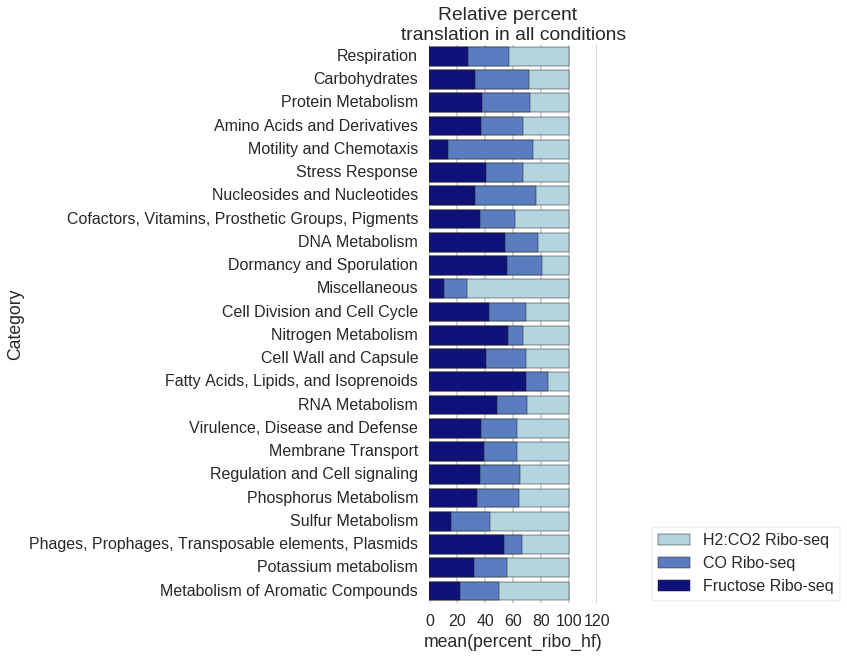

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_context('poster')
f, (ax1) = plt.subplots(1, figsize=(3, 10))
sns.set_color_codes("muted")
sns.barplot(x="ribo_sum_row", y="Category", data=category_accross_rows,label="H2:CO2 Ribo-seq", color="lightblue", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="co_hf_ribo_row", y="Category", data=category_accross_rows, label="CO Ribo-seq", color="b", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="percent_ribo_hf", y="Category", data=category_accross_rows, label="Fructose Ribo-seq", color="darkblue", ax=ax1)
ax1.set_title("Relative percent  \ntranslation in all conditions")
sns.despine(left=True, bottom=True, ax=ax1)
ax1.legend(ncol=1, bbox_to_anchor=(2.5, 0.15), frameon=True,)

plt.show()

In [30]:
category_accross_rows=category_accross_rows.sort_values(by='percent_ribo_hf_col', ascending = True)

In [31]:
category_accross_rows=category_accross_rows.sort_values(by='ribo_sum_col', ascending = False)

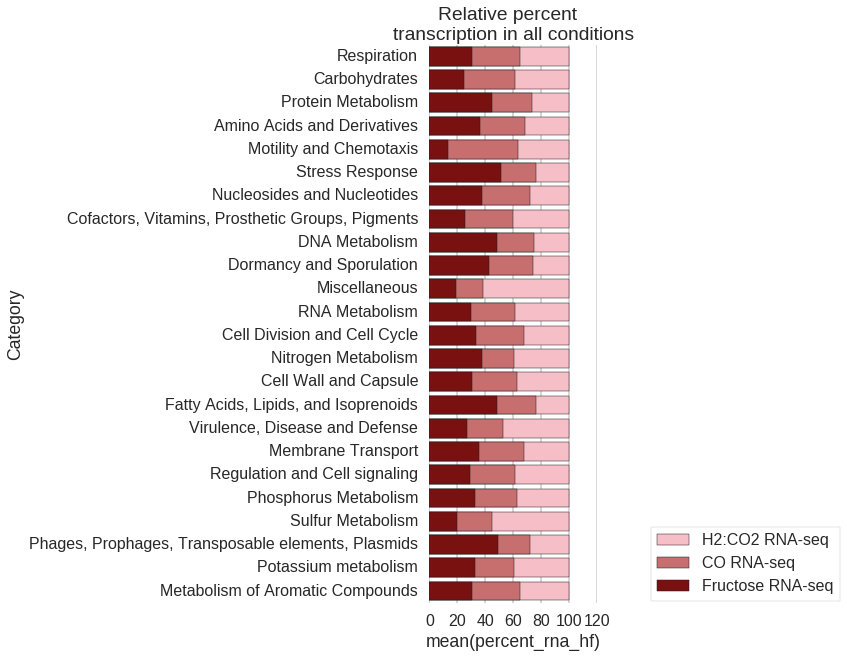

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_context('poster')
f, (ax1) = plt.subplots(1, figsize=(3, 10))
sns.set_color_codes("muted")
sns.barplot(x="rna_sum_row", y="Category", data=category_accross_rows,label="H2:CO2 RNA-seq", color="lightpink", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="co_hf_rna_row", y="Category", data=category_accross_rows, label="CO RNA-seq", color="r", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="percent_rna_hf", y="Category", data=category_accross_rows, label="Fructose RNA-seq", color="darkred", ax=ax1)
ax1.set_title("Relative percent  \ntranscription in all conditions")
sns.despine(left=True, bottom=True, ax=ax1)
ax1.legend(ncol=1, bbox_to_anchor=(2.5, 0.15), frameon=True,)

plt.show()

In [32]:
category_accross_rows=category_accross_rows.sort_values(by='percent_ribo_hf_col', ascending = True)

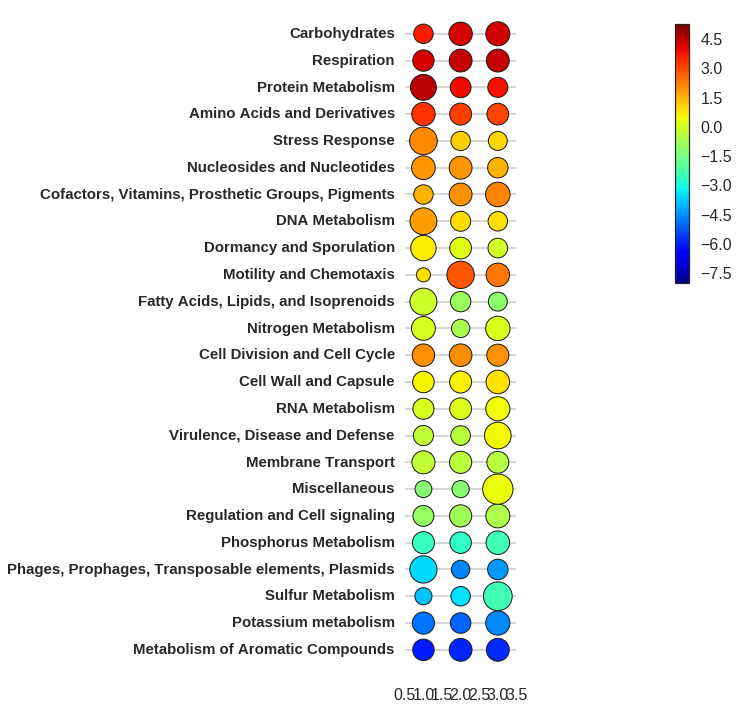

In [22]:
subcategory=np.arange(0,24,1)

hf_x = np.full(24, 1)
co_x = np.full(24, 2)
h2_x = np.full(24, 3)

fig,ax =plt.subplots(figsize=(2,12))
sns.set_style('white')
sns.despine( bottom=True, left=True)
ax.tick_params(axis='y', pad=10)
#cm = plt.cm.get_cmap('YlGnBu')
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x=hf_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_hf)*15,c=np.log2(category_accross_rows.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1,vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax.scatter(x=co_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_co)*15,c=np.log2(category_accross_rows.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1,vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax.scatter(x=h2_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_h2c)*15,c=np.log2(category_accross_rows.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1,vmin=np.log2(0.004), vmax=np.log2(40))
ax.set_yticks(np.arange(0,24,1))
ax.set_yticklabels(category_accross_rows.Category, fontsize=15, fontweight='bold')
ax.set_ylim(-1,24)
ax.grid()
ax.xaxis.grid()
ax.tick_params(axis='y', pad=10)
position=fig.add_axes([2,.58 ,0.1,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
#cbar.ax.set_yticklabels([])
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RASTpercent_transcription_per_subcat20170501.pdf', bbox_inches='tight')

# Counting RAST subcategories, subsystems and genes

In [59]:
test=df.groupby(['Category'])['Subcategory'].agg({'Subcategory':lambda x: x.nunique()})
test['subsystem']=df.groupby(['Category'])['Subsystem'].agg({lambda x: x.nunique()})
test['genes']=df.groupby(['Category'])['gene_id'].agg({lambda x: x.nunique()})
test=test.drop('Clustering-based subsystems', axis=0)
test=test.reset_index()
test.to_excel('/home/m/Dropbox/Clostridium_paper/table_of_RAST_CAT_subCAT_subSYS_genes_counts.xls')

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


In [60]:
category_accross_rows = df.groupby(['Subcategory','Category']).sum()
#category_accross_rows=category_accross_rows.drop(['Clustering-based subsystems'], axis=0) #removed a category that doesn't mean anything!
category_accross_rows=category_accross_rows.reset_index()

In [61]:
len(category_accross_rows)

100

In [62]:
category_accross_rows['percent_ribo_co_col']=(category_accross_rows.av_ribo_rpkm_co/category_accross_rows.av_ribo_rpkm_co.sum())*100
category_accross_rows['percent_ribo_hf_col']=(category_accross_rows.av_ribo_rpkm_hf/category_accross_rows.av_ribo_rpkm_hf.sum())*100
category_accross_rows['percent_ribo_h2c_col']=(category_accross_rows.av_ribo_rpkm_h2c/category_accross_rows.av_ribo_rpkm_h2c.sum())*100
category_accross_rows['percent_rna_co_col']=(category_accross_rows.av_rna_rpkm_co/category_accross_rows.av_rna_rpkm_co.sum())*100
category_accross_rows['percent_rna_hf_col']=(category_accross_rows.av_rna_rpkm_hf/category_accross_rows.av_rna_rpkm_hf.sum())*100
category_accross_rows['percent_rna_h2c_col']=(category_accross_rows.av_rna_rpkm_h2c/category_accross_rows.av_rna_rpkm_h2c.sum())*100

ribo_sum = category_accross_rows['percent_ribo_co_col']+category_accross_rows['percent_ribo_hf_col']+\
category_accross_rows['percent_ribo_h2c_col']
rna_sum = category_accross_rows['percent_rna_co_col']+category_accross_rows['percent_rna_hf_col']+\
category_accross_rows['percent_rna_h2c_col']

category_accross_rows['percent_ribo_co']= (category_accross_rows['percent_ribo_co_col']/ribo_sum)  *100
category_accross_rows['percent_ribo_hf']= (category_accross_rows['percent_ribo_hf_col']/ribo_sum)  *100
category_accross_rows['percent_ribo_h2c']=(category_accross_rows['percent_ribo_h2c_col']/ribo_sum) *100

category_accross_rows['percent_rna_co']= (category_accross_rows['percent_rna_co_col']/rna_sum) *100
category_accross_rows['percent_rna_hf']= (category_accross_rows['percent_rna_hf_col']/rna_sum) *100
category_accross_rows['percent_rna_h2c']=(category_accross_rows['percent_rna_h2c_col']/rna_sum)*100

category_accross_rows['ribo_sum_row']=category_accross_rows.percent_ribo_co+category_accross_rows.percent_ribo_hf+category_accross_rows.percent_ribo_h2c
category_accross_rows['rna_sum_row']=category_accross_rows.percent_rna_co+category_accross_rows.percent_rna_hf+category_accross_rows.percent_rna_h2c
category_accross_rows['co_hf_ribo_row']=category_accross_rows.percent_ribo_co+category_accross_rows.percent_ribo_hf
category_accross_rows['co_hf_rna_row']=category_accross_rows.percent_rna_co+category_accross_rows.percent_rna_hf


category_accross_rows['ribo_sum_col']=((category_accross_rows['percent_ribo_co_col']+\
                                        category_accross_rows['percent_ribo_hf_col']+\
                                        category_accross_rows['percent_ribo_h2c_col'])/300)*100
category_accross_rows['minus_ribo_sum_col']=category_accross_rows.ribo_sum_col*-1
category_accross_rows['rna_sum_col']=((category_accross_rows['percent_rna_co_col']+\
                                       category_accross_rows['percent_rna_hf_col']+\
                                       category_accross_rows['percent_rna_h2c_col'])/300) *100

In [63]:
len(category_accross_rows)

100

In [64]:
category_accross_rows=category_accross_rows.set_index('Category')

In [65]:
category_accross_rows=category_accross_rows.ix[['Carbohydrates','Respiration','Protein Metabolism', 'Cell Division and Cell Cycle']]

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [66]:
category_accross_rows=category_accross_rows.reset_index()
category_accross_rows=category_accross_rows.groupby(['Category','Subcategory']).sum()

In [67]:
category_accross_rows=category_accross_rows.reset_index()

In [68]:
len(category_accross_rows)

17

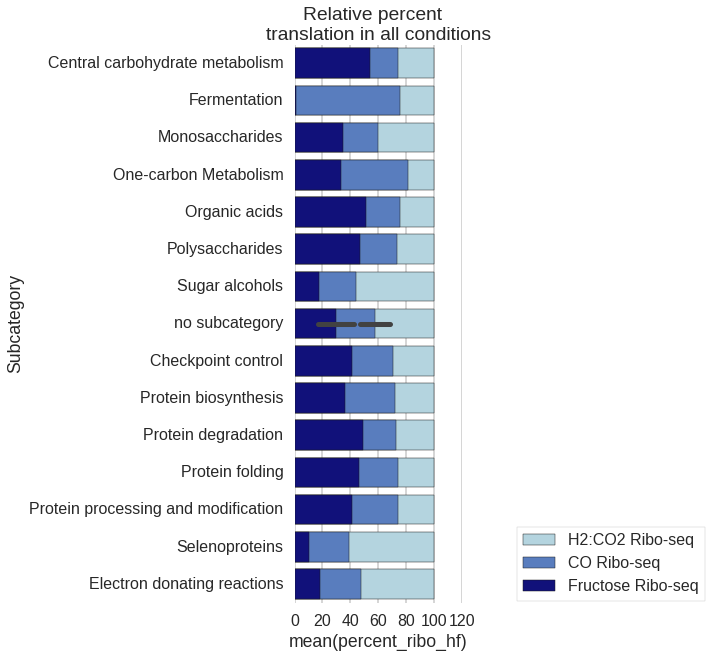

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_context('poster')
f, (ax1) = plt.subplots(1, figsize=(3, 10))
sns.set_color_codes("muted")
sns.barplot(x="ribo_sum_row", y="Subcategory", data=category_accross_rows,label="H2:CO2 Ribo-seq", color="lightblue", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="co_hf_ribo_row", y="Subcategory", data=category_accross_rows, label="CO Ribo-seq", color="b", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="percent_ribo_hf", y="Subcategory", data=category_accross_rows, label="Fructose Ribo-seq", color="darkblue", ax=ax1)
ax1.set_title("Relative percent  \ntranslation in all conditions")
sns.despine(left=True, bottom=True, ax=ax1)
ax1.legend(ncol=1, bbox_to_anchor=(2.5, 0.15), frameon=True,)

plt.show()

# subsystems, subcategories, catetories

In [69]:
df.columns

Index([u'gene_id', u'old_gene_id', u'av_ribo_rpkm_co', u'av_ribo_rpkm_hf',
       u'av_ribo_rpkm_h2c', u'av_rna_rpkm_co', u'av_rna_rpkm_hf',
       u'av_rna_rpkm_h2c', u'Unnamed: 0', u'Feature ID', u'locus', u'Category',
       u'Subcategory', u'Subsystem', u'Role', u'Organism A'],
      dtype='object')

In [70]:
category_accross_rows = df.groupby(['Subsystem','Subcategory','Category']).sum()
#category_accross_rows=category_accross_rows.drop(['Clustering-based subsystems'], axis=0) #removed a category that doesn't mean anything!
category_accross_rows=category_accross_rows.reset_index()

In [71]:
len(category_accross_rows)

301

In [72]:
category_accross_rows.columns


Index([u'Subsystem', u'Subcategory', u'Category', u'av_ribo_rpkm_co',
       u'av_ribo_rpkm_hf', u'av_ribo_rpkm_h2c', u'av_rna_rpkm_co',
       u'av_rna_rpkm_hf', u'av_rna_rpkm_h2c', u'Unnamed: 0'],
      dtype='object')

In [73]:
category_accross_rows['percent_ribo_co_col']=(category_accross_rows.av_ribo_rpkm_co/category_accross_rows.av_ribo_rpkm_co.sum())*100
category_accross_rows['percent_ribo_hf_col']=(category_accross_rows.av_ribo_rpkm_hf/category_accross_rows.av_ribo_rpkm_hf.sum())*100
category_accross_rows['percent_ribo_h2c_col']=(category_accross_rows.av_ribo_rpkm_h2c/category_accross_rows.av_ribo_rpkm_h2c.sum())*100
category_accross_rows['percent_rna_co_col']=(category_accross_rows.av_rna_rpkm_co/category_accross_rows.av_rna_rpkm_co.sum())*100
category_accross_rows['percent_rna_hf_col']=(category_accross_rows.av_rna_rpkm_hf/category_accross_rows.av_rna_rpkm_hf.sum())*100
category_accross_rows['percent_rna_h2c_col']=(category_accross_rows.av_rna_rpkm_h2c/category_accross_rows.av_rna_rpkm_h2c.sum())*100

ribo_sum = category_accross_rows['percent_ribo_co_col']+category_accross_rows['percent_ribo_hf_col']+\
category_accross_rows['percent_ribo_h2c_col']
rna_sum = category_accross_rows['percent_rna_co_col']+category_accross_rows['percent_rna_hf_col']+\
category_accross_rows['percent_rna_h2c_col']

category_accross_rows['percent_ribo_co']= (category_accross_rows['percent_ribo_co_col']/ribo_sum)  *100
category_accross_rows['percent_ribo_hf']= (category_accross_rows['percent_ribo_hf_col']/ribo_sum)  *100
category_accross_rows['percent_ribo_h2c']=(category_accross_rows['percent_ribo_h2c_col']/ribo_sum) *100

category_accross_rows['percent_rna_co']= (category_accross_rows['percent_rna_co_col']/rna_sum) *100
category_accross_rows['percent_rna_hf']= (category_accross_rows['percent_rna_hf_col']/rna_sum) *100
category_accross_rows['percent_rna_h2c']=(category_accross_rows['percent_rna_h2c_col']/rna_sum)*100

category_accross_rows['ribo_sum_row']=category_accross_rows.percent_ribo_co+category_accross_rows.percent_ribo_hf+category_accross_rows.percent_ribo_h2c
category_accross_rows['rna_sum_row']=category_accross_rows.percent_rna_co+category_accross_rows.percent_rna_hf+category_accross_rows.percent_rna_h2c
category_accross_rows['co_hf_ribo_row']=category_accross_rows.percent_ribo_co+category_accross_rows.percent_ribo_hf
category_accross_rows['co_hf_rna_row']=category_accross_rows.percent_rna_co+category_accross_rows.percent_rna_hf


category_accross_rows['ribo_sum_col']=((category_accross_rows['percent_ribo_co_col']+\
                                        category_accross_rows['percent_ribo_hf_col']+\
                                        category_accross_rows['percent_ribo_h2c_col'])/300)*100
category_accross_rows['minus_ribo_sum_col']=category_accross_rows.ribo_sum_col*-1
category_accross_rows['rna_sum_col']=((category_accross_rows['percent_rna_co_col']+\
                                       category_accross_rows['percent_rna_hf_col']+\
                                       category_accross_rows['percent_rna_h2c_col'])/300) *100

In [74]:
category_accross_rows=category_accross_rows.replace('inf',0.0)

In [75]:

category_accross_rows['te_co_subsystem']= category_accross_rows.percent_ribo_co_col / category_accross_rows.percent_rna_co_col
category_accross_rows['te_hf_subsystem']= category_accross_rows.percent_ribo_hf_col / category_accross_rows.percent_rna_hf_col
category_accross_rows['te_h2c_subsystem']= category_accross_rows.percent_ribo_h2c_col/ category_accross_rows.percent_rna_h2c_col


In [76]:
total = (category_accross_rows['te_co_subsystem']+category_accross_rows['te_hf_subsystem']+\
        category_accross_rows['te_h2c_subsystem'])
category_accross_rows['percent_te_co_subsystem']=category_accross_rows['te_co_subsystem']/total *100
category_accross_rows['percent_te_hf_subsystem']=category_accross_rows['te_hf_subsystem']/total *100
category_accross_rows['percent_te_h2c_subsystem']=category_accross_rows['te_h2c_subsystem']/total *100

In [77]:
category_accross_rows=category_accross_rows.groupby(['Category','Subcategory','Subsystem']).sum()
category_accross_rows=category_accross_rows.reset_index()
#category_accross_rows=category_accross_rows.sort_values(by='percent_', ascending=False)
category_accross_rows=category_accross_rows.replace('inf',0.0)

#filtering out all the CBSS subsystems, which do not have any meaning!
category_accross_rows=category_accross_rows[category_accross_rows.Subsystem.str.contains('CBSS')==False]
len(category_accross_rows)

271

In [78]:
category_accross_rows.to_excel('/home/m/Desktop/test.xls')
category_accross_rows.sort_values(by='percent_ribo_h2c_col', inplace=True, ascending=True)
category_accross_rows=category_accross_rows[category_accross_rows.Subsystem.str.contains('hydroggenase')==False]
len(category_accross_rows)

271

In [79]:
category_accross_rows.to_excel('/home/m/Dropbox/Clostridium_paper/Rast_categories_table_used_to_make_figure2.xls')

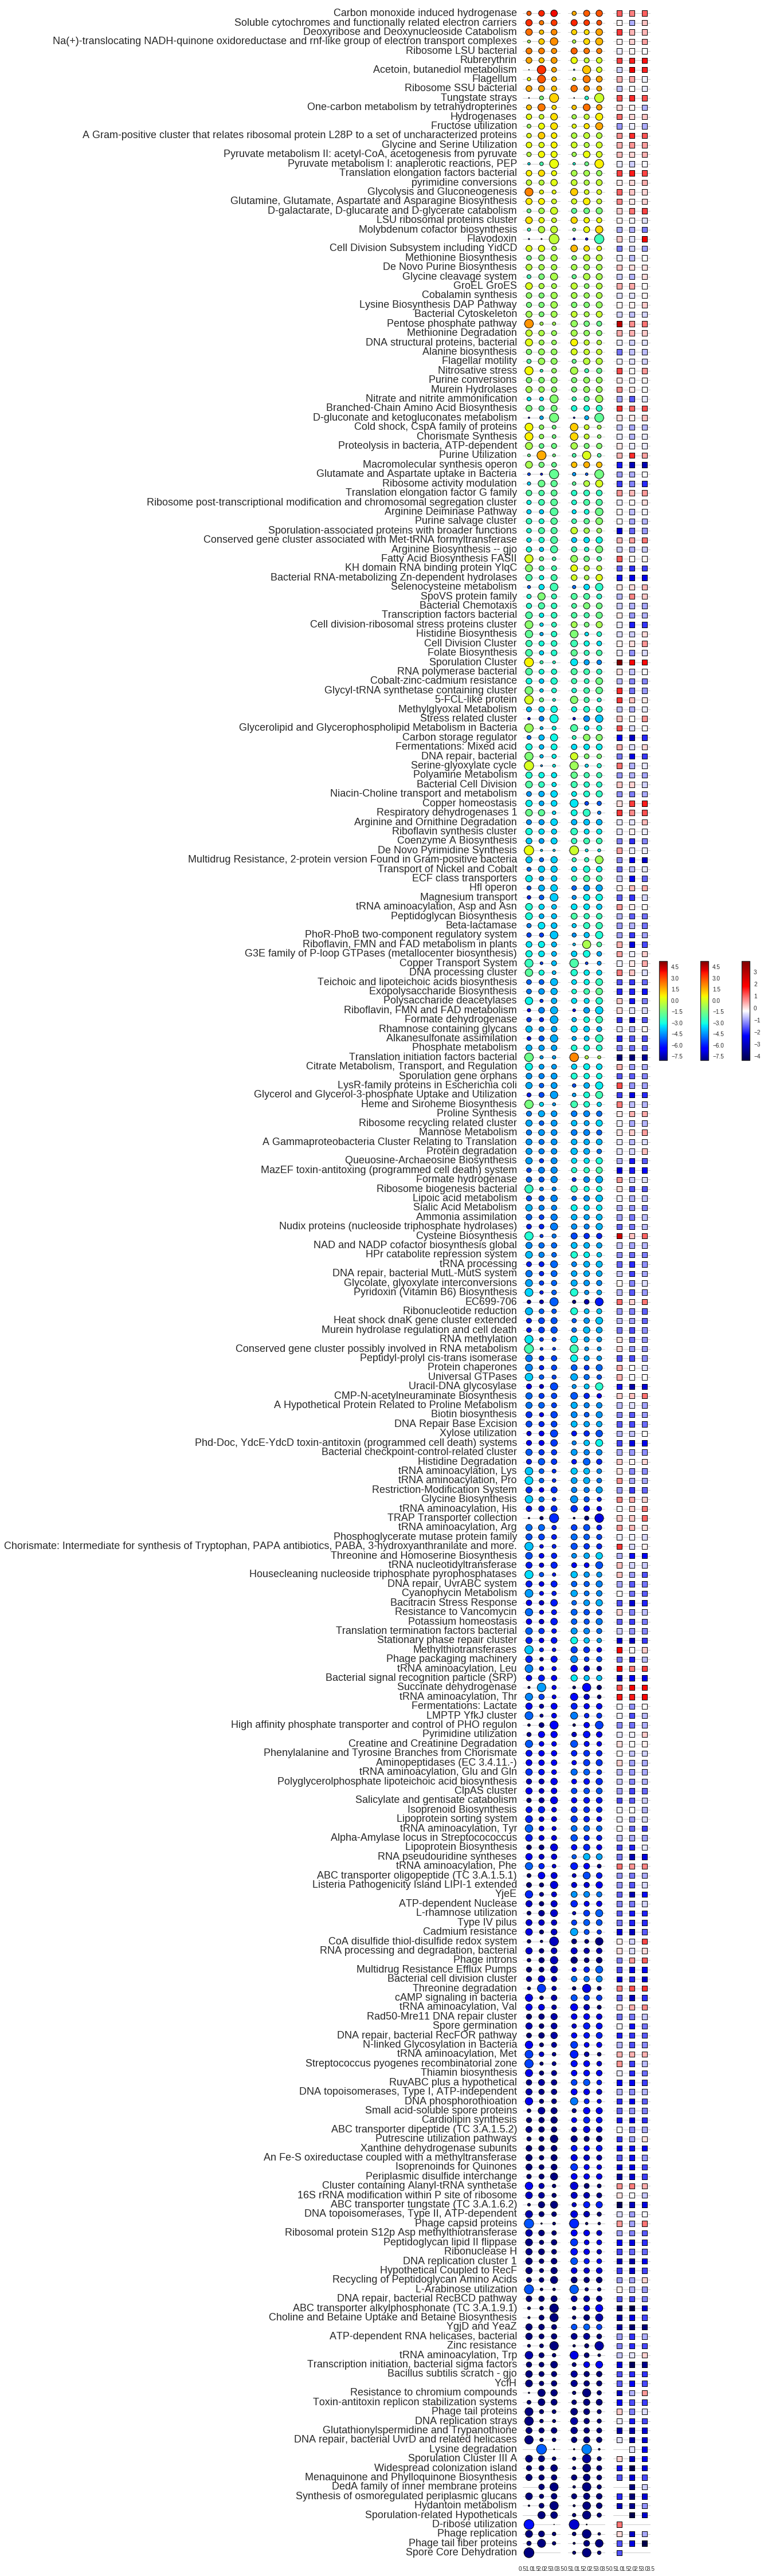

In [48]:
ddff=category_accross_rows
subcategory=np.arange(0,len(ddff),1)

hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(4,80), sharey=True)
sns.set_style('white')
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)

cm = plt.cm.get_cmap('jet')
sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(category_accross_rows.percent_ribo_hf)*3,c=np.log2(category_accross_rows.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(category_accross_rows.percent_ribo_co)*3,c=np.log2(category_accross_rows.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(category_accross_rows.percent_ribo_h2c)*3,c=np.log2(category_accross_rows.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(category_accross_rows.Subsystem, fontsize=18)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)

position=fig.add_axes([0.95,.58 ,0.05,0.03])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )

cm = plt.cm.get_cmap('jet')
sc = ax2.scatter(x=hf_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_hf)*3,c=np.log2(category_accross_rows.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=co_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_co)*3,c=np.log2(category_accross_rows.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=h2_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_h2c)*3,c=np.log2(category_accross_rows.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax2.set_yticks(np.arange(0,len(ddff),1))
ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()

position=fig.add_axes([1.2,.58 ,0.05,0.03])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )

cm = plt.cm.get_cmap('seismic')
vmaxx=15
vminn = 0.05
sc = ax3.scatter(x=hf_x, y=subcategory, \
                s=90,c=np.log2(category_accross_rows.te_hf_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker= 's')

sc = ax3.scatter(x=co_x, y=subcategory, \
                s=90,c=np.log2(category_accross_rows.te_co_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker = 's')

sc = ax3.scatter(x=h2_x, y=subcategory, \
                s=90,c=np.log2(category_accross_rows.te_h2c_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='s')
ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.45,.58 ,0.05,0.03])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/all_subcategories_sorted_by_percent_ribo_h2c_col.pdf',
           bbox_inches='tight')

## Figure 6 related TE plot

In [80]:
hiTESubs = pd.read_excel('/home/m/Dropbox/Clostridium_paper/fig6_highTE_SubsystemDF.xls')
lowTESubs= pd.read_excel('/home/m/Dropbox/Clostridium_paper/fig6_lowTE_SubsystemDF.xls')

In [81]:
hiTESubs = pd.merge(hiTESubs, category_accross_rows, on='Subsystem')
lowTESubs= pd.merge(lowTESubs,category_accross_rows, on= 'Subsystem')

In [82]:
hihetro=hiTESubs[hiTESubs['Subsystem count_hetero']!=0]
hiauto=hiTESubs[hiTESubs['Subsystem count_auto']!=0]

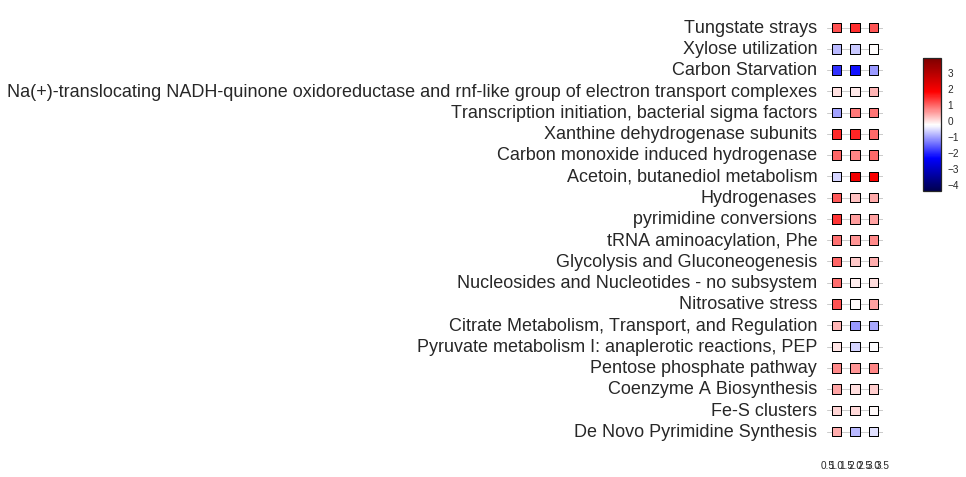

In [226]:
ddff=hiTESubs[::-1]
subcategory=np.arange(0,len(ddff),1)
subcategoryte=subcategory[::-1]
hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)

fig,ax3 =plt.subplots(figsize=(1,8), sharey=True)
sns.set_style('white')
sns.despine( bottom=True, left=True)
ax3.tick_params(axis='y', pad=10)

ax3.set_yticklabels(ddff.Subsystem, fontsize=18)

cm = plt.cm.get_cmap('seismic')
vmaxx=15
vminn = 0.05
sc = ax3.scatter(x=hf_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_hf_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker= 's')

sc = ax3.scatter(x=co_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_co_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker = 's')

sc = ax3.scatter(x=h2_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_h2c_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='s')
ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.45,.58 ,0.25,0.23])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )
#plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/all_subcategories_sorted_by_percent_ribo_h2c_col.pdf',
#           bbox_inches='tight')

# ---------------------------------------------------------------------

## Figure 6 second trial, the one above didn't show the point.
1. I will get differentially transcribed subsystems
2. classify them whether they are differentially TE in autotrophic, heterotrohpic, or not differentially TE at all. 
3. compare how TE responds to mRNA concentration
4. if the differentially TE subsystems show response to mRNA concentration then we show this figure as a main figure
5. compare the features for subystems that are Differentially TE versus ones that are not and show that the features in the mRNA play a major role in controlling differential TE. 


In [83]:
# getting differential TE 
auto_DTE = category_accross_rows[(category_accross_rows.percent_te_co_subsystem > category_accross_rows.percent_te_hf_subsystem) &
                                (category_accross_rows.percent_te_h2c_subsystem > category_accross_rows.percent_te_hf_subsystem)]

het_DTE =category_accross_rows[(category_accross_rows.percent_te_hf_subsystem > category_accross_rows.percent_te_co_subsystem  ) &
                              (category_accross_rows.percent_te_hf_subsystem >category_accross_rows.percent_te_h2c_subsystem ) ]

0.685193885412
0.685193885412
0.516552387198


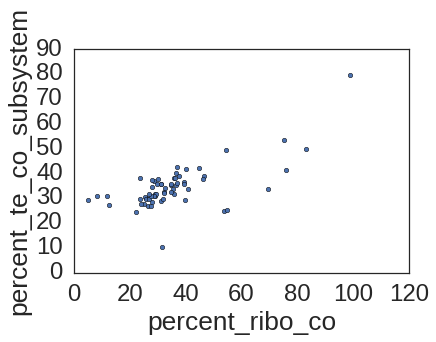

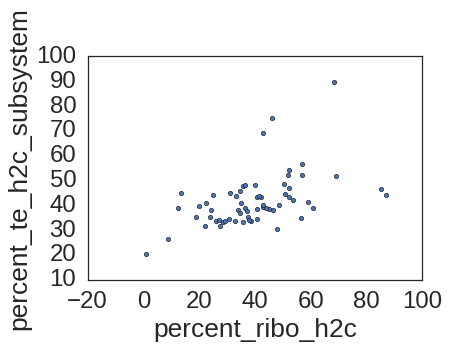

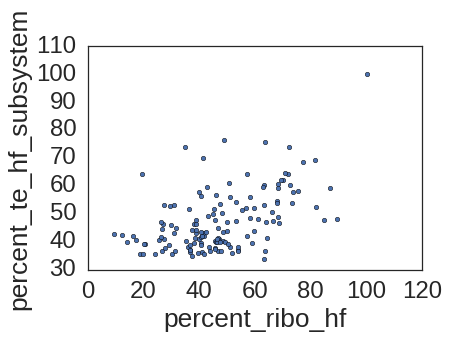

In [84]:
auto_DTE.plot.scatter('percent_ribo_co', 'percent_te_co_subsystem' )
print auto_DTE.percent_ribo_co.corr(auto_DTE.percent_te_co_subsystem, method='pearson')
auto_DTE.plot.scatter('percent_ribo_h2c', 'percent_te_h2c_subsystem' )
print auto_DTE.percent_ribo_co.corr(auto_DTE.percent_te_co_subsystem, method='pearson')

het_DTE.plot.scatter('percent_ribo_hf', 'percent_te_hf_subsystem' )
print het_DTE.percent_ribo_hf.corr(het_DTE.percent_te_hf_subsystem, method='pearson')

In [95]:
category_accross_rows['log2diffCOHF'] = np.log2(category_accross_rows.percent_te_co_subsystem/
                                               category_accross_rows.percent_te_hf_subsystem)
category_accross_rows['log2diffH2CHF']= np.log2(category_accross_rows.percent_te_h2c_subsystem/
                                               category_accross_rows.percent_te_hf_subsystem)
category_accross_rows['log2diffH2CHF_ribo']=np.log2(category_accross_rows.percent_ribo_h2c/
                                                   category_accross_rows.percent_ribo_hf)
category_accross_rows['log2diffCOHF_ribo']=np.log2(category_accross_rows.percent_ribo_co/
                                                   category_accross_rows.percent_ribo_hf)
category_accross_rows['log2diffCOHF_rna']=np.log2(category_accross_rows.percent_rna_co/
                                                   category_accross_rows.percent_rna_hf)
category_accross_rows['log2diffH2CHF_rna']=np.log2(category_accross_rows.percent_rna_h2c/
                                                   category_accross_rows.percent_rna_hf)

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log2
/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log2
/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log2
/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log2


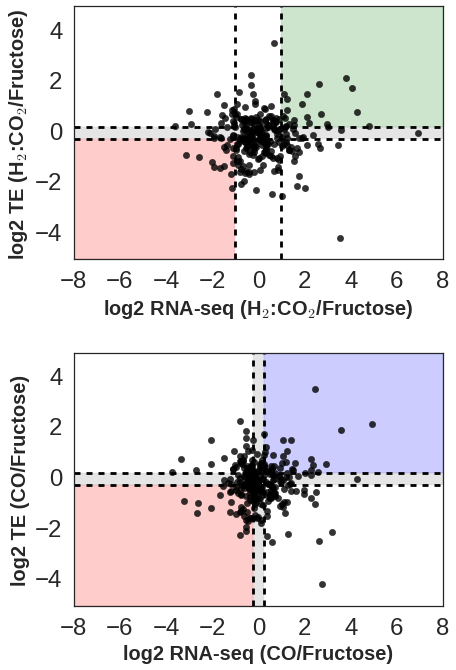

In [96]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(7,10))
sns.set_style('white')
ax1.fill_between((1,8), 0.25,5, color='green', alpha=0.2)
ax1.fill_between((-8,-1), -5, -0.25, color='red', alpha=0.2)
ax1.fill_between((-8,8), -0.25, 0.25, color='grey', alpha=0.2)
sns.set_context('poster', font_scale=1.5)
category_accross_rows.plot.scatter('log2diffH2CHF_rna', 'log2diffH2CHF', ax=ax1,
                                   s=40, alpha=0.8, color='black')
ax1.hlines(0.25, -8,8, linestyles='dashed', color='black')
ax1.hlines(-0.25, -8,8, linestyles='dashed', color='black')
ax1.set_xlim(-8,8)
ax1.set_ylim(-5,5)
ax1.set_ylabel('log2 TE (H$_2$:CO$_2$/Fructose)', fontsize=20, fontweight='bold')
ax1.set_xlabel('log2 RNA-seq (H$_2$:CO$_2$/Fructose)', fontsize=20, fontweight='bold')


ax1.vlines(1,-5,5, linestyles='dashed', color='black')
ax1.vlines(-1,-5,5, linestyles='dashed', color='black')





ax2.fill_between((0.25,8), 0.25,5, color='blue', alpha=0.2)
ax2.fill_between((-8,-0.25), -0.25, -5, color='red', alpha=0.2)
ax2.fill_between((-8,8), -0.25, 0.25, color='grey', alpha=0.2)
ax2.fill_between((-0.25,0.25), -5, 5, color='grey', alpha=0.2)
ax2.hlines(0.25, -8,8, linestyles='dashed',)
ax2.hlines(-0.25, -8,8, linestyles='dashed', )
#ax2.hlines(1, -8,8, linestyles='dashed')
#ax2.hlines(-1, -8,8, linestyles='dashed')
ax2.vlines(0.25,-5,5, linestyles='dashed')
ax2.vlines(-0.25,-5,5, linestyles='dashed')

category_accross_rows.plot.scatter('log2diffCOHF_rna', 'log2diffH2CHF', ax=ax2,
                                  s=40, alpha=0.8, color='black')



ax2.set_xlim(-8,8)
ax2.set_ylim(-5,5)
ax2.set_ylabel('log2 TE (CO/Fructose)', fontsize=20, fontweight='bold')
ax2.set_xlabel('log2 RNA-seq (CO/Fructose)', fontsize=20, fontweight='bold')

plt.tight_layout()


In [93]:
auto_co=category_accross_rows[(category_accross_rows.log2diffCOHF>0.25) &
                              (category_accross_rows.log2diffCOHF_ribo>0.25)]
auto_h2c=category_accross_rows[(category_accross_rows.log2diffH2CHF>0.25) &
                              (category_accross_rows.log2diffH2CHF_ribo>0.25)]
het_co = category_accross_rows[(category_accross_rows.log2diffCOHF< -0.25) &
                              (category_accross_rows.log2diffCOHF_ribo< -0.25)]
het_h2c= category_accross_rows[(category_accross_rows.log2diffH2CHF< -0.25) &
                              (category_accross_rows.log2diffH2CHF_ribo< -0.25)]
not_dif_cohf=category_accross_rows[(category_accross_rows.log2diffCOHF<=0.25) |
                                  (category_accross_rows.log2diffCOHF>=-0.25)]
not_dif_cohf=category_accross_rows[(category_accross_rows.log2diffCOHF_ribo<=1)|
                                  (category_accross_rows.log2diffCOHF_ribo>=-1)]

In [164]:
test=auto_co.sort_values(by='av_ribo_rpkm_co', ascending=False)[0:20]

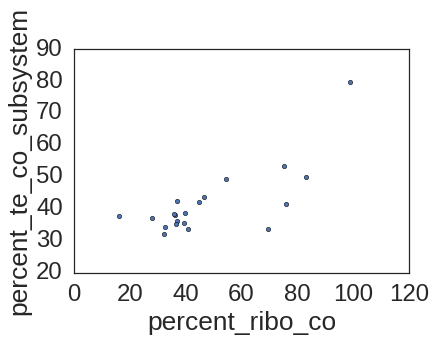

In [168]:
category_accross_rows.plot.scatter('percent_ribo_co', 'percent_te_co_subsystem', figsize=(6,4))

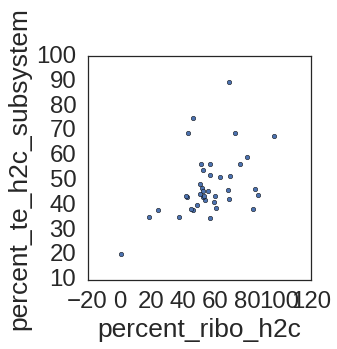

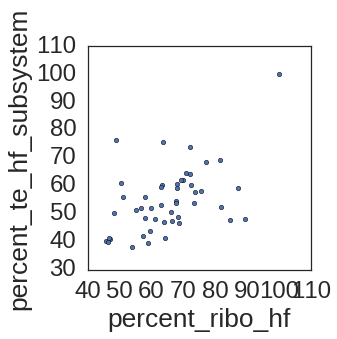

In [147]:
auto_h2c.plot.scatter('percent_ribo_h2c', 'percent_te_h2c_subsystem', figsize=(4,4))
het_h2c.plot.scatter('percent_ribo_hf', 'percent_te_hf_subsystem', figsize=(4,4))

## Showing the subsystems that are specifically translationally induced in H2:CO2. 
The criteria are:
1. subsystems must have >50% enrichment per subsystem
2. subsystems must be > 50 percentile of H2:CO2 total translation

In [133]:
h2c_subsystems=category_accross_rows[(category_accross_rows.percent_ribo_h2c>50) &
                                    (category_accross_rows.percent_ribo_h2c_col>
                                    np.percentile(category_accross_rows.percent_ribo_h2c_col,50))]

In [134]:
h2c_subsystems.to_excel('/home/m/Dropbox/Clostridium_paper/h2c_specific_subsystems.xls')

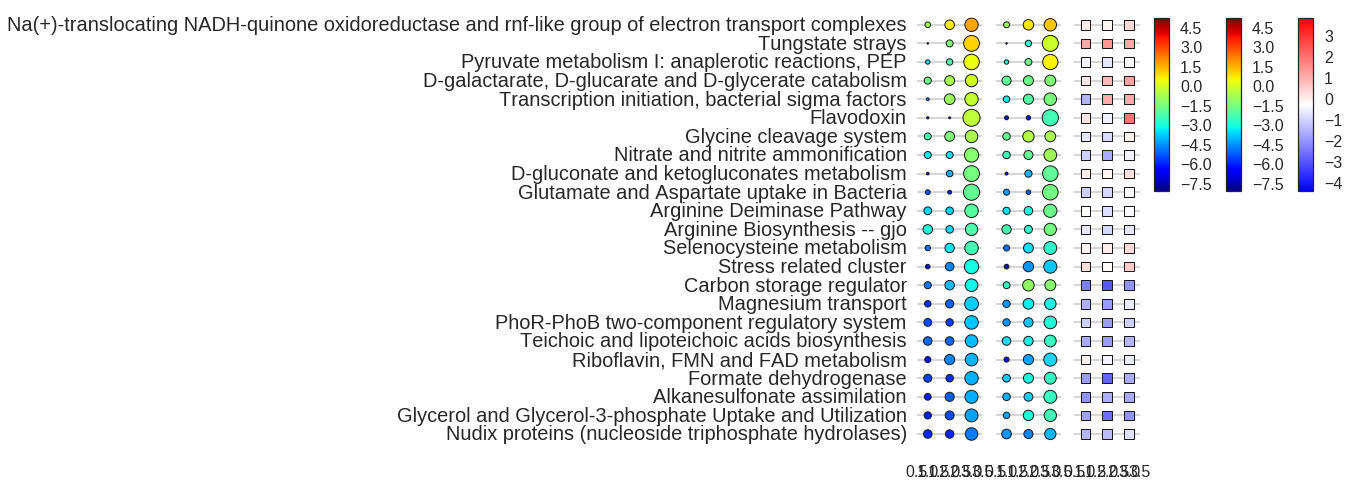

In [87]:
ddff=h2c_subsystems
subcategory=np.arange(0,len(ddff),1)

hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(4,8), sharey=True)
sns.set_style('white')
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)

cm = plt.cm.get_cmap('jet')
sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_ribo_hf)*3,c=np.log2(ddff.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_ribo_co)*3,c=np.log2(ddff.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_ribo_h2c)*3,c=np.log2(ddff.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(ddff.Subsystem, fontsize=20)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)
position=fig.add_axes([0.95,.58 ,0.05,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )

cm = plt.cm.get_cmap('jet')
sc = ax2.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_rna_hf)*3,c=np.log2(ddff.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_rna_co)*3,c=np.log2(ddff.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_rna_h2c)*3,c=np.log2(ddff.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax2.set_yticks(np.arange(0,len(ddff),1))
ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()
position=fig.add_axes([1.2,.58 ,0.05,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )

cm = plt.cm.get_cmap('bwr')
vmaxx=15
vminn = 0.05
sc = ax3.scatter(x=hf_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_hf_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='s')

sc = ax3.scatter(x=co_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_co_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='s')

sc = ax3.scatter(x=h2_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_h2c_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='s')
ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.45,.58 ,0.05,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )
#cbar.ax.set_yticklabels([-3.2,'',-1.6,'' ,0, '',1.6,'',3.2])

plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/h2c_subcats_sorted_by_percent_ribo_h2c_col.pdf',
           bbox_inches='tight')

## Showing the subsystems that are specifically translationally induced in CO. 
The criteria are:
1. subsystems must have >50% enrichment per subsystem
2. subsystems must be > 50 percentile of CO total translation

In [135]:
co_subsystems=category_accross_rows[(category_accross_rows.percent_ribo_co>50) &
                                    (category_accross_rows.percent_ribo_co_col>
                                    np.percentile(category_accross_rows.percent_ribo_co_col,50))]

In [136]:
co_subsystems.sort_values(by='percent_ribo_co_col', inplace=True)

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [137]:
co_subsystems.to_excel('/home/m/Dropbox/Clostridium_paper/CO_specific_subsystems.xls')

/home/m/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(7, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/m/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(7, 2) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/m/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(7, 3) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


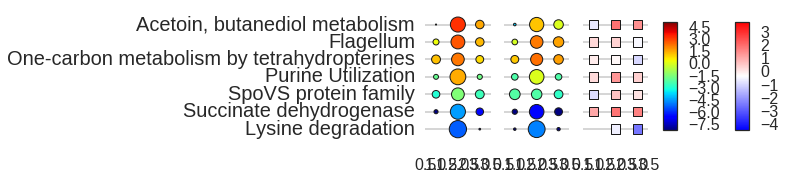

In [138]:
ddff=co_subsystems
subcategory=np.arange(0,len(ddff),1)

hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(4,2.5), sharey=True)
sns.set_style('white')
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)

cm = plt.cm.get_cmap('jet')
sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_ribo_hf)*3,c=np.log2(ddff.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_ribo_co)*3,c=np.log2(ddff.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_ribo_h2c)*3,c=np.log2(ddff.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(ddff.Subsystem, fontsize=20)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)
position=fig.add_axes([0.95,.22 ,0.05,0.6])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )

cm = plt.cm.get_cmap('jet')
sc = ax2.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_rna_hf)*3,c=np.log2(ddff.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_rna_co)*3,c=np.log2(ddff.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_rna_h2c)*3,c=np.log2(ddff.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax2.set_yticks(np.arange(0,len(ddff),1))
ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()


cm = plt.cm.get_cmap('bwr')
vmaxx=15
vminn = 0.05
sc = ax3.scatter(x=hf_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_hf_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='s')

sc = ax3.scatter(x=co_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_co_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='s')

sc = ax3.scatter(x=h2_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_h2c_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='s')
ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.2,.22 ,0.05,0.6])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )
#cbar.ax.set_yticklabels([-3.2,'',-1.6,'' ,0, '',1.6,'',3.2])

plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/co_subcats_sorted_by_percent_ribo_co_col.pdf',
           bbox_inches='tight')

# DESeq Significance to group condition-sepcific subsystems

1. DESeq was used to find significant differntial translation at the RAST subsystem level in HF, CO and H2CO2. Row data from two replicates were used in each condition. 

In [37]:
#DESeq ribo
co_hf_ribo_pval=pd.read_csv('/home/m/Downloads/ribo_co_hf', sep='\t')
co_hf_ribo_pval.index.name='Subsystem'#change the name of the index to Subsystem
co_hf_ribo_pval=co_hf_ribo_pval.reset_index()
co_hf_ribo_pval.columns = co_hf_ribo_pval.columns.str.replace('padj','p_co_hf') #change name of padj
co_hf_ribo_pval=co_hf_ribo_pval[['Subsystem','p_co_hf']]
co_h2c_ribo_pval=pd.read_csv('/home/m/Downloads/ribo_co_h2co2', sep='\t')
co_h2c_ribo_pval.index.name='Subsystem'
co_h2c_ribo_pval=co_h2c_ribo_pval.reset_index()
co_h2c_ribo_pval.columns = co_h2c_ribo_pval.columns.str.replace('padj','p_co_h2c')
co_h2c_ribo_pval=co_h2c_ribo_pval[['Subsystem','p_co_h2c']]
hf_h2c_ribo_pval=pd.read_csv('/home/m/Downloads/ribo_hf_h2co2', sep='\t')
hf_h2c_ribo_pval.index.name='Subsystem'
hf_h2c_ribo_pval=hf_h2c_ribo_pval.reset_index()
hf_h2c_ribo_pval.columns = hf_h2c_ribo_pval.columns.str.replace('padj','p_hf_h2c')
hf_h2c_ribo_pval=hf_h2c_ribo_pval[['Subsystem','p_hf_h2c']]

#DESeq RNA
co_hf_rna_pval=pd.read_csv('/home/m/Downloads/rna_co_hf', sep='\t')
co_hf_rna_pval.index.name='Subsystem'
co_hf_rna_pval=co_hf_rna_pval.reset_index()
co_hf_rna_pval.columns = co_hf_rna_pval.columns.str.replace('padj','p_co_hf_rna')
co_hf_rna_pval=co_hf_rna_pval[['Subsystem','p_co_hf_rna']]
co_h2c_rna_pval=pd.read_csv('/home/m/Downloads/rna_co_h2co2', sep='\t')
co_h2c_rna_pval.index.name='Subsystem'
co_h2c_rna_pval=co_h2c_rna_pval.reset_index()
co_h2c_rna_pval.columns = co_h2c_rna_pval.columns.str.replace('padj','p_co_h2c_rna')
co_h2c_rna_pval=co_h2c_rna_pval[['Subsystem','p_co_h2c_rna']]
hf_h2c_rna_pval=pd.read_csv('/home/m/Downloads/rna_hf_h2co2', sep='\t')
hf_h2c_rna_pval.index.name='Subsystem'
hf_h2c_rna_pval=hf_h2c_rna_pval.reset_index()
hf_h2c_rna_pval.columns = hf_h2c_rna_pval.columns.str.replace('padj','p_hf_h2c_rna')
hf_h2c_rna_pval=hf_h2c_rna_pval[['Subsystem','p_hf_h2c_rna']]

#merging dfs into "pv"
pvalues = pd.merge(co_hf_ribo_pval,(pd.merge(co_h2c_ribo_pval,hf_h2c_ribo_pval)))
pvalues1=pd.merge(co_hf_rna_pval, (pd.merge(co_h2c_rna_pval,hf_h2c_rna_pval)))
pv=pd.merge(pvalues,pvalues1)

In [38]:
#merging pv with category_accross_rows
category_accross_rows=pd.merge(category_accross_rows,pv, on='Subsystem')
category_accross_rows=category_accross_rows.sort_values(by='percent_ribo_hf_col', ascending=False)
#category_accross_rows=category_accross_rows.replace('NaN',1.0)

In [39]:
category_accross_rows.head()

Category                      Subcategory  \
269         Respiration                   no subcategory   
270         Respiration                   no subcategory   
268       Carbohydrates                  Monosaccharides   
266  Protein Metabolism             Protein biosynthesis   
251       Carbohydrates  Central carbohydrate metabolism   

                                             Subsystem  av_ribo_rpkm_co  \
269  Soluble cytochromes and functionally related e...     39643.026743   
270                Carbon monoxide induced hydrogenase     90513.249081   
268         Deoxyribose and Deoxynucleoside Catabolism     19398.971952   
266                             Ribosome LSU bacterial     36685.112032   
251                     Glycolysis and Gluconeogenesis      9465.806264   

     av_ribo_rpkm_hf  av_ribo_rpkm_h2c  av_rna_rpkm_co  av_rna_rpkm_hf  \
269     91081.878021      69600.723938    81290.682727   119790.117492   
270     57756.369944     115050.544908    58205.474307    32865.551811   
268     48240.012664      33048.602773    16863.581216    22441.116402   
266     42170.847784      30476.049594    44933.732645    65501.925449   
251     41040.389417       8947.814337     8881.820473    24110.191478   

     av_rna_rpkm_h2c  Unnamed: 0      ...       te_h2c_subsystem  \
269     59517.319999        5782      ...               1.236929   
270     58450.876337       13488      ...               2.081958   
268     26870.278838        8100      ...               1.300934   
266     37226.336446       37263      ...               0.865930   
251      8633.448762       15249      ...               1.096243   

     percent_te_co_subsystem  percent_te_hf_subsystem  \
269                20.279252                34.008482   
270                29.365563                35.694338   
268                24.906613                50.060949   
266                35.832193                30.392377   
251                27.532494                47.298907   

     percent_te_h2c_subsystem       p_co_hf  p_co_h2c      p_hf_h2c  \
269                 45.712266  1.382291e-01  0.160019  9.858615e-01   
270                 34.940099  2.235546e-14  0.289045  3.133421e-19   
268                 25.032439  8.185287e-05  0.004455  4.109700e-01   
266                 33.775430  3.798178e-03  0.003553  9.310903e-01   
251                 25.168599  2.503892e-25  0.084095  1.155642e-35   

      p_co_hf_rna  p_co_h2c_rna  p_hf_h2c_rna  
269  1.234169e-01  8.007923e-02  4.350681e-04  
270  6.601017e-31  1.531604e-02  2.417692e-46  
268  8.965732e-01  1.572393e-14  1.375527e-14  
266  7.322357e-01  3.969009e-01  1.916663e-01  
251  4.084553e-18  2.197921e-01  2.723253e-13  

[5 rows x 41 columns]

In [40]:
category_accross_rows[['Subsystem', u'p_co_hf', u'p_co_h2c', u'p_hf_h2c',
       u'p_co_hf_rna', u'p_co_h2c_rna', u'p_hf_h2c_rna']].head(5)


Subsystem       p_co_hf  \
269  Soluble cytochromes and functionally related e...  1.382291e-01   
270                Carbon monoxide induced hydrogenase  2.235546e-14   
268         Deoxyribose and Deoxynucleoside Catabolism  8.185287e-05   
266                             Ribosome LSU bacterial  3.798178e-03   
251                     Glycolysis and Gluconeogenesis  2.503892e-25   

     p_co_h2c      p_hf_h2c   p_co_hf_rna  p_co_h2c_rna  p_hf_h2c_rna  
269  0.160019  9.858615e-01  1.234169e-01  8.007923e-02  4.350681e-04  
270  0.289045  3.133421e-19  6.601017e-31  1.531604e-02  2.417692e-46  
268  0.004455  4.109700e-01  8.965732e-01  1.572393e-14  1.375527e-14  
266  0.003553  9.310903e-01  7.322357e-01  3.969009e-01  1.916663e-01  
251  0.084095  1.155642e-35  4.084553e-18  2.197921e-01  2.723253e-13

genes were first grouped into susbsystems that show increased translation in Heterotrophic growth or increased translation in autotrophic growth (CO and H2CO2). DESeq2 was used to obtain significance values for translational differnce. Ribo-seq read counts were summed per each RAST subsystem for each replicate and DESeq values were obtained. Significant difference was based on adjusted p-values < 0.01.
Ribo-seq and RNA-seq RPKM and FPKM values, repspecitively, were rescalled to percentiles. Subsystems with percentiles lower than 50% in all three conditions were discarded in downstream analysis. Heterotorphic enriched subsystems were selected based on Ribo-seq values significantly larger than those in autotrophic (CO and H2CO2). Whereas Autotrophically enriched subsystems were those having significantly larger values in both CO and H2CO2 relative to fructose. 

In [41]:
category_accross_rows.te_co_subsystem.replace(0.0, 0.0000001, inplace=True)
category_accross_rows.te_h2c_subsystem.replace(0.0, 0.0000001, inplace=True)
category_accross_rows.te_hf_subsystem.replace(0.0, 0.0000001, inplace=True)

In [42]:
category_accross_rows[category_accross_rows.Subcategory.str.contains('Electron donating reactions')].to_excel('/home/m/Desktop/temp.xls')

In [43]:
df[df.Role.str.contains('Rnf')].sort_values(by='av_ribo_rpkm_hf',\
                                            ascending=False)

gene_id  old_gene_id  av_ribo_rpkm_co  av_ribo_rpkm_hf  \
452  CLJU_RS05585  CLJU_c11390      2276.464251      1574.212732   
453  CLJU_RS05590  CLJU_c11400      1636.122473      1410.030380   
450  CLJU_RS05575  CLJU_c11370      3164.142120      1117.767057   
454  CLJU_RS05595  CLJU_c11410      2582.326945       542.516758   
451  CLJU_RS05580  CLJU_c11380      1304.495234       419.895444   
449  CLJU_RS05570  CLJU_c11360      2348.764568        52.534122   

     av_ribo_rpkm_h2c  av_rna_rpkm_co  av_rna_rpkm_hf  av_rna_rpkm_h2c  \
452       4147.979291     2244.391050     1006.099517      2971.595074   
453       3666.405454     2879.684384     1213.007948      4135.326701   
450       6262.833182     2284.298260      824.056174      2866.222246   
454       5465.828294     2803.147732     1175.325044      3642.205414   
451       1571.581510     2590.813135     1119.212719      3273.305455   
449       4034.990558     2560.702509      621.713437      3080.784434   

     Unnamed: 0 Feature ID         locus     Category  \
452         511   peg.1103  CLJU_RS05585  Respiration   
453         512   peg.1104  CLJU_RS05590  Respiration   
450         509   peg.1101  CLJU_RS05575  Respiration   
454         513   peg.1105  CLJU_RS05595  Respiration   
451         510   peg.1102  CLJU_RS05580  Respiration   
449         508   peg.1100  CLJU_RS05570  Respiration   

                     Subcategory  \
452  Electron donating reactions   
453  Electron donating reactions   
450  Electron donating reactions   
454  Electron donating reactions   
451  Electron donating reactions   
449  Electron donating reactions   

                                             Subsystem  \
452  Na(+)-translocating NADH-quinone oxidoreductas...   
453  Na(+)-translocating NADH-quinone oxidoreductas...   
450  Na(+)-translocating NADH-quinone oxidoreductas...   
454  Na(+)-translocating NADH-quinone oxidoreductas...   
451  Na(+)-translocating NADH-quinone oxidoreductas...   
449  Na(+)-translocating NADH-quinone oxidoreductas...   

                                        Role Organism A  
452  Electron transport complex protein RnfE   peg.1103  
453  Electron transport complex protein RnfA   peg.1104  
450  Electron transport complex protein RnfD   peg.1101  
454  Electron transport complex protein RnfB   peg.1105  
451  Electron transport complex protein RnfG   peg.1102  
449  Electron transport complex protein RnfC   peg.1100

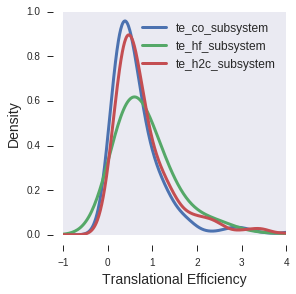

In [44]:
fig, ax = plt.subplots(figsize=(4,4))
sns.set_style('ticks')
sns.despine(offset=10, ax=ax)
(category_accross_rows.te_co_subsystem).plot(kind='kde', legend=True, linewidth=3, ax=ax)
(category_accross_rows.te_hf_subsystem).plot(kind='kde', legend=True, linewidth=3, ax=ax)
(category_accross_rows.te_h2c_subsystem).plot(kind='kde', legend=True, linewidth=3, ax=ax)
ax.set_xlim(-1,4)
ax.set_xlabel('Translational Efficiency', fontsize = 14)
ax.set_ylabel('Density', fontsize=14)
ax.legend(fontsize=12)

In [45]:
#category_accross_rows.percent_te_co_subsystem.fillna(0.0, inplace=True)
#category_accross_rows.percent_te_h2c_subsystem.fillna(0.0, inplace=True)
#category_accross_rows.percent_te_hf_subsystem.fillna(0.0, inplace=True)

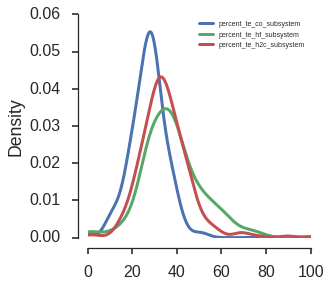

In [83]:
fig, ax = plt.subplots(figsize=(4,4))
sns.set_style('ticks')

(category_accross_rows.percent_te_co_subsystem).plot(kind='kde', legend=True, linewidth=3, ax=ax)
(category_accross_rows.percent_te_hf_subsystem).plot(kind='kde', legend=True, linewidth=3, ax=ax)
(category_accross_rows.percent_te_h2c_subsystem).plot(kind='kde', legend=True, linewidth=3, ax=ax)
ax.set_xlim(0,100)
ax.legend(fontsize=7)
sns.despine(offset=10, ax=ax)

In [48]:
category_accross_rows.to_excel('./category_accross_rows.xls')

In [46]:
category_accross_rows1=category_accross_rows[['Category', 'Subcategory', 'Subsystem', 'av_ribo_rpkm_co',
       'av_ribo_rpkm_hf', 'av_ribo_rpkm_h2c', 'av_rna_rpkm_co',
       'av_rna_rpkm_hf', 'av_rna_rpkm_h2c','percent_ribo_co_col', 'percent_ribo_hf_col',
       'percent_ribo_h2c_col', 'percent_rna_co_col', 'percent_rna_hf_col',
       'percent_rna_h2c_col', 'percent_ribo_co', 'percent_ribo_hf',
       'percent_ribo_h2c', 'percent_rna_co', 'percent_rna_hf',
       'percent_rna_h2c','te_co_subsystem', 'te_hf_subsystem',
       'te_h2c_subsystem','p_co_hf',
       'p_co_h2c', 'p_hf_h2c']]

In [47]:
category_accross_rows1.to_excel('/home/m/Desktop/temp.xls')

## Heterotrophic subsystems

In [51]:
sig=0.01
#hf vs co or h2co2 should be significant in ribo-seq whether hetero>auto or hetero<auto
hf = category_accross_rows[(category_accross_rows.p_co_hf<sig) & (category_accross_rows.p_hf_h2c<sig) &\
                           (category_accross_rows.p_co_h2c>sig)]

#and we only consider subsystems that have over 50th percentile of translation in at least one condition
hf = hf[(category_accross_rows.percent_ribo_hf_col>np.percentile(category_accross_rows.percent_ribo_hf_col,50))]
#hetero significantly > auto if ribo-hf >ribo-co and ribo-hf > ribo-h2c
Hetero_increase=hf[(hf.percent_ribo_hf>hf.percent_ribo_co)\
                   & (hf.percent_ribo_hf>hf.percent_ribo_h2c)]


hf_sig=Hetero_increase[(Hetero_increase.percent_te_hf_subsystem>Hetero_increase.percent_te_co_subsystem) &
                       (Hetero_increase.percent_te_hf_subsystem>Hetero_increase.percent_te_h2c_subsystem)]
hf_sig.set_index('Subsystem', inplace=True)
Hetero_increase.set_index('Subsystem',inplace=True)

AttributeError: 'DataFrame' object has no attribute 'p_co_hf'

In [149]:
sig=0.01
co_h2= category_accross_rows[(category_accross_rows.p_co_hf<sig) & (category_accross_rows.p_hf_h2c<sig)]
co_h2 = co_h2[(category_accross_rows.percent_ribo_co_col>np.percentile(category_accross_rows.percent_ribo_co_col,50)) &\
         (category_accross_rows.percent_ribo_h2c_col>np.percentile(category_accross_rows.percent_ribo_h2c_col, 50))]
             
Auto_increase = co_h2[(co_h2.percent_ribo_co>co_h2.percent_ribo_hf) & (co_h2.percent_ribo_h2c>co_h2.percent_ribo_hf)]


co_co2_sig=Auto_increase[(Auto_increase.percent_te_co_subsystem>Auto_increase.percent_te_hf_subsystem)&
                       (Auto_increase.percent_te_h2c_subsystem>Auto_increase.percent_te_hf_subsystem) ]
co_co2_sig.set_index('Subsystem', inplace=True)
Auto_increase.set_index('Subsystem',inplace=True)

In [150]:
len(co_co2_sig)

16

### find subsystems with significantly different TE

In [151]:
#################### HETEROTROPHIC ###############################


line_edge=[]
hetero_label=[]
for i,r in Hetero_increase.iterrows():
    if i in np.array(hf_sig.index):
        hetero_label.append('^')
        line_edge.append(2.5)
    else:
        hetero_label.append('v')
        line_edge.append(1)
Hetero_increase.reset_index(inplace=True)
Hetero_increase.loc[:,'sigs']=hetero_label
Hetero_increase.loc[:,'line']=line_edge
#hf_sig.reset_index(inplace=True)

In [152]:
################### AUTOTROPHIC ########################


line_edge=[]
auto_label=[]
for i,r in Auto_increase.iterrows():
    if i in np.array(co_co2_sig.index):
        auto_label.append('^')
        line_edge.append(2.5)
    else:
        auto_label.append('v')
        line_edge.append(1)
Auto_increase.reset_index(inplace=True)
Auto_increase.loc[:,'sigs']=auto_label
Auto_increase.loc[:,'line']=line_edge
#hf_sig.reset_index(inplace=True)

In [153]:
subcategory[::-1]

array([6, 5, 4, 3, 2, 1, 0])

In [50]:
ss='H'
ar1=list(range(1,21))
ar2=[]
for i in ar1:
    ar2.append('%s%s'%(ss,i))
ar3=[]
for i,j in zip(list(Hetero_increase.Subsystem), ar2):
    ar3.append ('%s %s'%(i,j))

NameError: name 'Hetero_increase' is not defined

/home/m/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


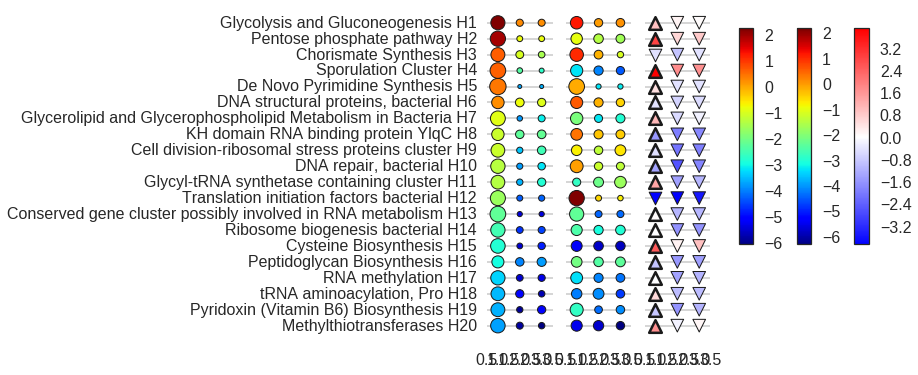

In [101]:
ddff=Hetero_increase[0:20]
ddff['Subsystem']=ar3
ddff=ddff.sort_index(ascending=False)
subcategory=np.arange(0,len(ddff),1)
subcategoryte=subcategory[::-1]
hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(4,6), sharey=True)
sns.set_style('white')
sns.set_context('poster',)
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)
vma=max(ddff[['percent_ribo_hf_col','percent_ribo_co_col','percent_ribo_h2c_col']].max())
vmi=min(ddff[['percent_ribo_hf_col','percent_ribo_co_col','percent_ribo_h2c_col']].min())
cm = plt.cm.get_cmap('jet')
sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_ribo_hf)*3,c=np.log2(ddff.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_ribo_co)*3,c=np.log2(ddff.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_ribo_h2c)*3,c=np.log2(ddff.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))
ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(ddff.Subsystem, fontsize=16)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)
position=fig.add_axes([1,.35 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
#cbar.ax.set_yticklabels([-6,'',-4,'' ,-2, '',0,'',2])

vmax=max(ddff[['percent_rna_hf_col','percent_rna_co_col','percent_rna_h2c_col']].max())
vmin=min(ddff[['percent_rna_hf_col','percent_rna_co_col','percent_rna_h2c_col']].min())
cm = plt.cm.get_cmap('jet')
sc = ax2.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_rna_hf)*3,c=np.log2(ddff.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))

sc = ax2.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_rna_co)*3,c=np.log2(ddff.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))

sc = ax2.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_rna_h2c)*3,c=np.log2(ddff.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))
ax2.set_yticks(np.arange(0,len(ddff),1))
ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()
position=fig.add_axes([1.2,.35 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
#cbar.ax.set_yticklabels([-6,'',-4,'' ,-2, '',0,'',2])
vmaxx=max(ddff[['te_hf_subsystem','te_co_subsystem','te_h2c_subsystem']].max())
vminn=min(ddff[['te_hf_subsystem','te_co_subsystem','te_h2c_subsystem']].min())
cm = plt.cm.get_cmap('bwr')

for i,row in ddff.iterrows():
    sc = ax3.scatter(x=hf_x[i], y=subcategoryte[i],s=160,c=np.log2(row['te_hf_subsystem']),
                     cmap=cm,linewidth=row['line'],alpha=1, vmin=np.log2(vminn), 
                     vmax=np.log2(vmaxx),marker=row['sigs'])

sc = ax3.scatter(x=co_x, y=subcategory, \
                s=160,c=np.log2(ddff.te_co_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='v')

sc = ax3.scatter(x=h2_x, y=subcategory, \
                s=160,c=np.log2(ddff.te_h2c_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='v')
ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.4,.35 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )
#cbar.ax.set_yticklabels([-3.2,'',-1.6,'' ,0, '',1.6,'',3.2])

plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RAST_subsystem_significant_TE_heterotrophic.pdf', bbox_inches='tight')

/home/m/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(19, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/m/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(19, 2) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/m/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(19, 3) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


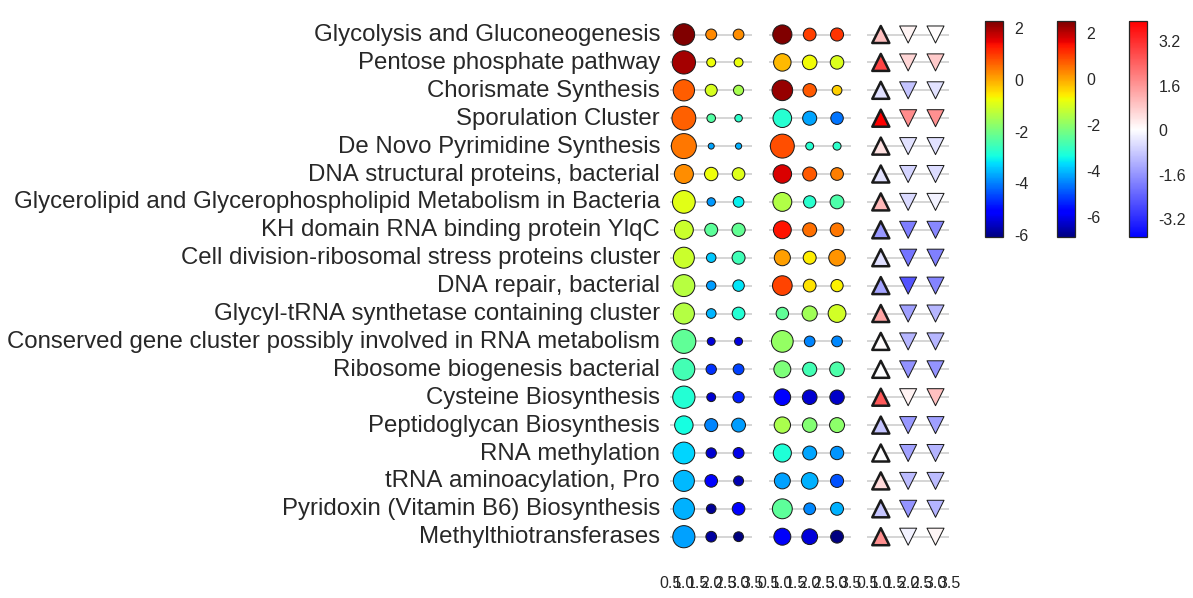

In [61]:
####only those with diff TE

ddff=Hetero_increase[0:20]
ddff=ddff.sort_index(ascending=False)
ddff=ddff[ddff.line==2.5]
subcategory=np.arange(0,len(ddff),1)
subcategoryte=subcategory[::-1]

hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)
s_factor=7
fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(5,10), sharey=True)
sns.set_style('white')
sns.set_context('poster',)
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)
vma=max(ddff[['percent_ribo_hf_col','percent_ribo_co_col','percent_ribo_h2c_col']].max())
vmi=min(ddff[['percent_ribo_hf_col','percent_ribo_co_col','percent_ribo_h2c_col']].min())
vmax=max(ddff[['percent_rna_hf_col','percent_rna_co_col','percent_rna_h2c_col']].max())
vmin=min(ddff[['percent_rna_hf_col','percent_rna_co_col','percent_rna_h2c_col']].min())
vmaxx=max(Hetero_increase[['te_hf_subsystem','te_co_subsystem','te_h2c_subsystem']].max())
vminn=min(Hetero_increase[['te_hf_subsystem','te_co_subsystem','te_h2c_subsystem']].min())

cm = plt.cm.get_cmap('jet')

sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_ribo_hf)*s_factor,c=np.log2(ddff.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_ribo_co)*s_factor,c=np.log2(ddff.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_ribo_h2c)*s_factor,c=np.log2(ddff.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

cm = plt.cm.get_cmap('jet')
sc1 = ax2.scatter(x=hf_x, y=subcategory, 
                s=(ddff.percent_rna_hf)*s_factor,c=np.log2(ddff.percent_rna_hf_col),cmap=cm,
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))

sc1 = ax2.scatter(x=co_x, y=subcategory,
                s=(ddff.percent_rna_co)*s_factor,c=np.log2(ddff.percent_rna_co_col),cmap=cm,
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))

sc1 = ax2.scatter(x=h2_x, y=subcategory, 
                s=(ddff.percent_rna_h2c)*s_factor,c=np.log2(ddff.percent_rna_h2c_col),cmap=cm,
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))


cm = plt.cm.get_cmap('bwr')



sc2 = ax3.scatter(x=hf_x, y=subcategory,s=290,c=np.log2(ddff['te_hf_subsystem']),
                  cmap=cm,linewidth=2.5,alpha=1, vmin=np.log2(vminn), 
                  vmax=np.log2(vmaxx),marker='^')

sc2 = ax3.scatter(x=co_x, y=subcategory, 
                s=290,c=np.log2(ddff.te_co_subsystem),cmap=cm,
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='v')

sc2 = ax3.scatter(x=h2_x, y=subcategory, 
                s=290,c=np.log2(ddff.te_h2c_subsystem),cmap=cm,
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='v')

ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(ddff.Subsystem, fontsize=24)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)
position=fig.add_axes([1,.58 ,0.05,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
cbar.ax.set_yticklabels([-6,'',-4,'' ,-2, '',0,'',2])   

ax2.set_yticks(np.arange(0,len(ddff),1))
ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()
position=fig.add_axes([1.2,.58 ,0.05,0.3])
cbar=fig.colorbar(sc1,cax=position, use_gridspec=False)
cbar.ax.set_yticklabels([-6,'',-4,'' ,-2, '',0,'',2])

ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.4,.58 ,0.05,0.3])
cbar=fig.colorbar(sc2,cax=position, use_gridspec=True, )
cbar.ax.set_yticklabels([-3.2,'',-1.6,'' ,0, '',1.6,'',3.2])

plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RAST_subsystem_significant_TE_heterotrophic_not_including_insig.pdf', bbox_inches='tight')

In [109]:
ddff.Subsystem

19                             Ribonucleotide reduction
18    Chorismate: Intermediate for synthesis of Tryp...
17                               Methylthiotransferases
16                  Pyridoxin (Vitamin B6) Biosynthesis
15                                      RNA methylation
14                           Peptidoglycan Biosynthesis
13                                Cysteine Biosynthesis
12                        Ribosome biogenesis bacterial
11    Conserved gene cluster possibly involved in RN...
10                             RNA polymerase bacterial
8                                 DNA repair, bacterial
7       Cell division-ribosomal stress proteins cluster
6                    KH domain RNA binding protein YlqC
5     Glycerolipid and Glycerophospholipid Metabolis...
4                       Macromolecular synthesis operon
3                          De Novo Pyrimidine Synthesis
2                                   Sporulation Cluster
1                             Pentose phosphate 

### Autotrophic subsystems

In [166]:
Auto_increase=Auto_increase.drop([2])# droping the cluster that relates ribosomal protein to sa set of unchar... genes

In [167]:
Auto_increase.sort_values(by='av_ribo_rpkm_co', ascending=False, inplace=True)

In [168]:
ar1=list(range(1,21))
ar2=[]
for i in ar1:
    ar2.append('%s%s'%('A',i))
ar3=[]
for i,j in zip(list(Auto_increase.Subsystem), ar2):
    ar3.append ('%s %s'%(i,j))

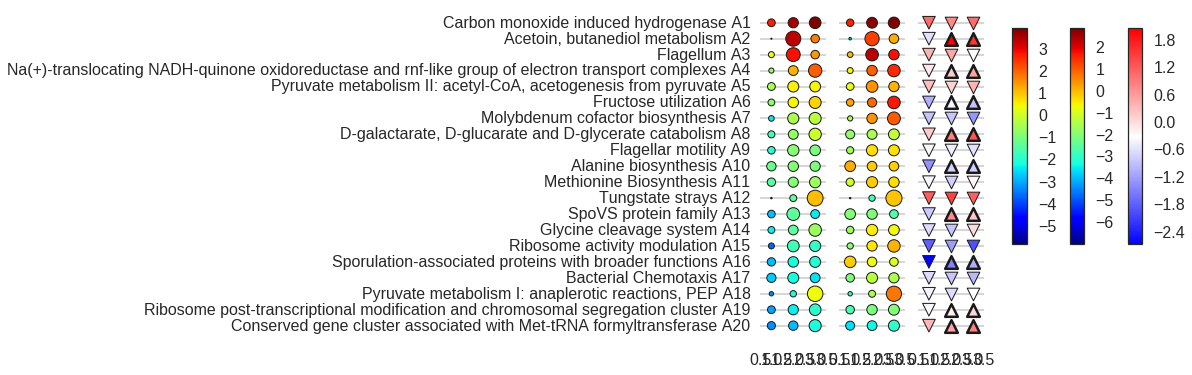

In [170]:
#Auto_increase=Auto_increase.sort_values(by=['percent_ribo_co_col'], ascending=False)
ddff=Auto_increase.sort_values(by='percent_ribo_co_col', ascending=False)[0:20]
ddff['Subsystem']=ar3
ddff.reset_index(inplace=True)
ddff.sort_index(ascending=False, inplace=True)
subcategory=np.arange(0,len(ddff),1)
subcategoryte=subcategory[::-1]
hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(4,6), sharey=True)
sns.set_style('white')
sns.set_context('poster',)
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)
vma=max(ddff[['percent_ribo_hf_col','percent_ribo_co_col','percent_ribo_h2c_col']].max())
vmi=min(ddff[['percent_ribo_hf_col','percent_ribo_co_col','percent_ribo_h2c_col']].min())
cm = plt.cm.get_cmap('jet')
sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_ribo_hf)*3,c=np.log2(ddff.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_ribo_co)*3,c=np.log2(ddff.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_ribo_h2c)*3,c=np.log2(ddff.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))
ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(ddff.Subsystem, fontsize=16)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)
position=fig.add_axes([1,.35 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
#cbar.ax.set_yticklabels([-5,'' ,-3, '',-1,'' ,1, '',3])
vmax=max(ddff[['percent_rna_hf_col','percent_rna_co_col','percent_rna_h2c_col']].max())
vmin=min(ddff[['percent_rna_hf_col','percent_rna_co_col','percent_rna_h2c_col']].min())
cm = plt.cm.get_cmap('jet')
sc = ax2.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_rna_hf)*3,c=np.log2(ddff.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))

sc = ax2.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_rna_co)*3,c=np.log2(ddff.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))

sc = ax2.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_rna_h2c)*3,c=np.log2(ddff.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))
ax2.set_yticks(np.arange(0,len(ddff),1))
ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()
position=fig.add_axes([1.2,.35 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
#cbar.ax.set_yticklabels([-5,'' ,-3, '',-1,'' ,1, '',2])
vmaxx=max(ddff[['te_hf_subsystem','te_co_subsystem','te_h2c_subsystem']].max())
vminn=min(ddff[['te_hf_subsystem','te_co_subsystem','te_h2c_subsystem']].min())
cm = plt.cm.get_cmap('bwr')
sc = ax3.scatter(x=hf_x, y=subcategory, \
                s=160,c=np.log2(ddff.te_hf_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='v')

for i,row in ddff.iterrows():
    sc = ax3.scatter(x=co_x[i], y=subcategoryte[i],s=160,c=np.log2(row['te_co_subsystem']),
                     cmap=cm,linewidth=row['line'],alpha=1, vmin=np.log2(vminn), 
                     vmax=np.log2(vmaxx),marker=row['sigs'])
    sc = ax3.scatter(x=h2_x[i], y=subcategoryte[i],s=160,c=np.log2(row['te_h2c_subsystem']),
                     cmap=cm,linewidth=row['line'],alpha=1, vmin=np.log2(vminn), 
                     vmax=np.log2(vmaxx),marker=row['sigs'])



ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.4,.35 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )
#cbar.ax.set_yticklabels([-2.4,'',-1.2,'' ,'',0.6,'',1.8])

plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RAST_subsystem_significant_TE_autotrophic.pdf', bbox_inches='tight')

Subsystem  \
0                 Carbon monoxide induced hydrogenase   
20                     Acetoin, butanediol metabolism   
1                                           Flagellum   
2   A Gram-positive cluster that relates ribosomal...   
4   Na(+)-translocating NADH-quinone oxidoreductas...   
3   Pyruvate metabolism II: acetyl-CoA, acetogenes...   
5                                Fructose utilization   
11                   Molybdenum cofactor biosynthesis   
8   D-galactarate, D-glucarate and D-glycerate cat...   
9                                  Flagellar motility   
6                                Alanine biosynthesis   
7                             Methionine Biosynthesis   
32                                   Tungstate strays   
13                               SpoVS protein family   
10                            Glycine cleavage system   
18                       Ribosome activity modulation   
14  Sporulation-associated proteins with broader f...   
12                               Bacterial Chemotaxis   
17  Pyruvate metabolism I: anaplerotic reactions, PEP   
15  Ribosome post-transcriptional modification and...   
16  Conserved gene cluster associated with Met-tRN...   
28                          Selenocysteine metabolism   
23                                     Beta-lactamase   
19                           Methylglyoxal Metabolism   
27                     Transport of Nickel and Cobalt   
26                           Carbon storage regulator   
21            Niacin-Choline transport and metabolism   
29                                         Hfl operon   
37          D-gluconate and ketogluconates metabolism   
24                                  Proline Synthesis   
22                 Arginine and Ornithine Degradation   
25                     Exopolysaccharide Biosynthesis   
36                             Stress related cluster   
35                 Riboflavin, FMN and FAD metabolism   
30  MazEF toxin-antitoxing (programmed cell death)...   
31                                Magnesium transport   
34                       Alkanesulfonate assimilation   
33  Glycerol and Glycerol-3-phosphate Uptake and U...   

                                            Category  \
0                                        Respiration   
20                                     Carbohydrates   
1                            Motility and Chemotaxis   
2                        Clustering-based subsystems   
4                                        Respiration   
3                                      Carbohydrates   
5                                      Carbohydrates   
11  Cofactors, Vitamins, Prosthetic Groups, Pigments   
8                                      Carbohydrates   
9                            Motility and Chemotaxis   
6                        Amino Acids and Derivatives   
7                        Amino Acids and Derivatives   
32                                     Miscellaneous   
13                          Dormancy and Sporulation   
10                       Amino Acids and Derivatives   
18                                Protein Metabolism   
14                          Dormancy and Sporulation   
12                           Motility and Chemotaxis   
17                                     Carbohydrates   
15                       Clustering-based subsystems   
16                       Clustering-based subsystems   
28                                Protein Metabolism   
23                    Virulence, Disease and Defense   
19                                     Carbohydrates   
27                                Membrane Transport   
26                                     Carbohydrates   
21                                     Miscellaneous   
29                                   Stress Response   
37                                     Carbohydrates   
24                       Amino Acids and Derivatives   
22                       Amino Acids and Derivatives   
25                          

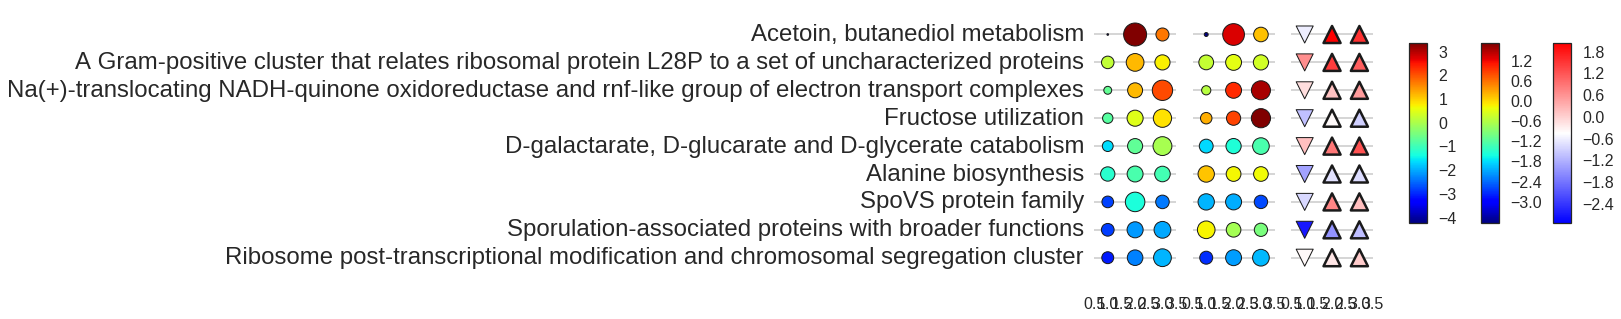

In [75]:
##only sig diff TE
ddff=Auto_increase.sort_values(by='percent_ribo_co_col', ascending=False)[0:20]
ddff.reset_index(inplace=True)
ddff.sort_index(ascending=False, inplace=True)
ddff=ddff[ddff['line']==2.5]
subcategory=np.arange(0,len(ddff),1)
subcategoryte=subcategory[::-1]
hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)
s_factor=7
fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(5,5), sharey=True)
sns.set_style('white')
sns.set_context('poster',)
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)
vma=max(ddff[['percent_ribo_hf_col','percent_ribo_co_col','percent_ribo_h2c_col']].max())
vmi=min(ddff[['percent_ribo_hf_col','percent_ribo_co_col','percent_ribo_h2c_col']].min())
cm = plt.cm.get_cmap('jet')
sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_ribo_hf)*s_factor,c=np.log2(ddff.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_ribo_co)*s_factor,c=np.log2(ddff.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_ribo_h2c)*s_factor,c=np.log2(ddff.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmi), vmax=np.log2(vma))
ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(ddff.Subsystem, fontsize=24)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)
position=fig.add_axes([1,.3 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
#cbar.ax.set_yticklabels([-5,'' ,-3, '',-1,'' ,1, '',3])
vmax=max(ddff[['percent_rna_hf_col','percent_rna_co_col','percent_rna_h2c_col']].max())
vmin=min(ddff[['percent_rna_hf_col','percent_rna_co_col','percent_rna_h2c_col']].min())
cm = plt.cm.get_cmap('jet')
sc = ax2.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_rna_hf)*s_factor,c=np.log2(ddff.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))

sc = ax2.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_rna_co)*s_factor,c=np.log2(ddff.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))

sc = ax2.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_rna_h2c)*s_factor,c=np.log2(ddff.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vmin), vmax=np.log2(vmax))
ax2.set_yticks(np.arange(0,len(ddff),1))
#ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()
position=fig.add_axes([1.2,.3 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
#cbar.ax.set_yticklabels([-5,'' ,-3, '',-1,'' ,1, '',2])
vmaxx=max(Auto_increase[['te_hf_subsystem','te_co_subsystem','te_h2c_subsystem']].max())
vminn=min(Auto_increase[['te_hf_subsystem','te_co_subsystem','te_h2c_subsystem']].min())
cm = plt.cm.get_cmap('bwr')
sc = ax3.scatter(x=hf_x, y=subcategory, \
                s=290,c=np.log2(ddff.te_hf_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx), marker='v')

sc = ax3.scatter(x=co_x, y=subcategory,s=290,c=np.log2(ddff['te_co_subsystem']),
                 cmap=cm,linewidth=2.5,alpha=1, vmin=np.log2(vminn), 
                 vmax=np.log2(vmaxx),marker='^')
sc = ax3.scatter(x=h2_x, y=subcategory,s=290,c=np.log2(ddff['te_h2c_subsystem']),
                 cmap=cm,linewidth=2.5,alpha=1, vmin=np.log2(vminn), 
                 vmax=np.log2(vmaxx),marker='^')



ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.4,.3 ,0.05,0.5])
cbar=fig.colorbar(sc,cax=position, use_gridspec=True, )
#cbar.ax.set_yticklabels([-2.4,'',-1.2,'' ,'',0.6,'',1.8])

plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RAST_subsystem_significant_TE_autotrophic_only_sig.pdf', bbox_inches='tight')

In [769]:
ddff.to_excel('/home/m/Desktop/temp.xls')

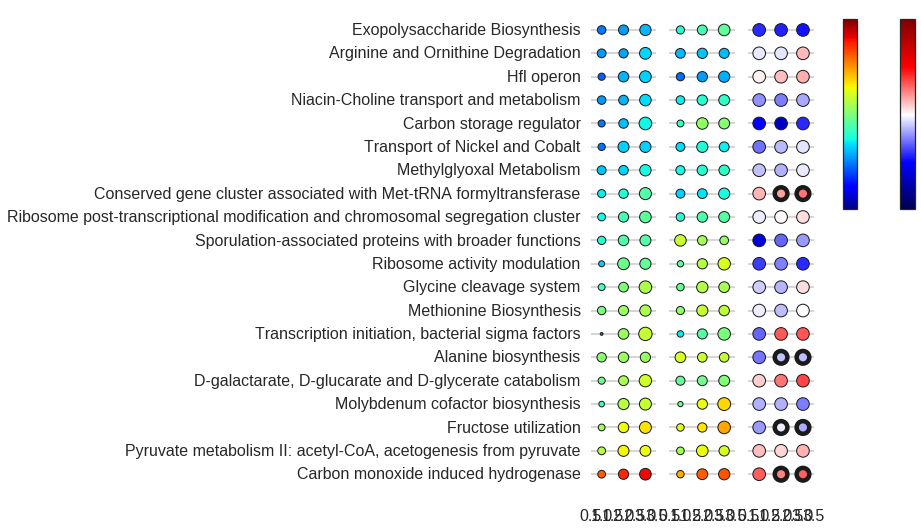

In [714]:
ddff=Auto_increase[0:20]
ddff=ddff.sort_values(by=['percent_ribo_co_col', 'percent_ribo_h2c_col'], ascending=False)

subcategory=np.arange(0,len(ddff),1)

hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(4,8.8), sharey=True)
sns.set_style('white')
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)

cm = plt.cm.get_cmap('jet')
sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_ribo_hf)*3,c=np.log2(ddff.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_ribo_co)*3,c=np.log2(ddff.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_ribo_h2c)*3,c=np.log2(ddff.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(ddff.Subsystem, fontsize=16)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)


cm = plt.cm.get_cmap('jet')
sc = ax2.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_rna_hf)*3,c=np.log2(ddff.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_rna_co)*3,c=np.log2(ddff.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_rna_h2c)*3,c=np.log2(ddff.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax2.set_yticks(np.arange(0,len(ddff),1))
ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()
position=fig.add_axes([1,.58 ,0.05,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
cbar.ax.set_yticklabels([])

cm = plt.cm.get_cmap('seismic')
vmaxx=15
vminn=0.05
sc = ax3.scatter(x=hf_x, y=subcategory, \
                s=160,c=np.log2(ddff.te_hf_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax= np.log2(vmaxx))

sc = ax3.scatter(x=co_x, y=subcategory, \
                s=160,c=np.log2(ddff.te_co_subsystem),cmap=cm,\
                linewidth=auto_edges,alpha=1, vmin=np.log2(vminn), vmax= np.log2(vmaxx))

sc = ax3.scatter(x=h2_x, y=subcategory, \
                s=160,c=np.log2(ddff.te_h2c_subsystem),cmap=cm,\
                linewidth=auto_edges,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx))
ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.2,.58 ,0.05,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
cbar.ax.set_yticklabels([])
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RAST_subsystem_significant_TE_autotrophic.pdf', bbox_inches='tight')

## Autotrophic condition comparison CO vs H2/CO2

In [305]:
sig=0.0001
co_auto= category_accross_rows[(category_accross_rows.p_co_h2c<sig)]
co_auto = co_auto[(co_auto.percent_ribo_co_col>np.percentile(co_auto.percent_ribo_co_col,50))]
             
             
co_increase = co_auto[ (co_auto.percent_ribo_co>co_auto.percent_ribo_h2c)]

co_sig=co_increase[(co_increase.te_co_subsystem>(np.median(co_increase.te_h2c_subsystem)+\
                         (1*np.std(co_increase.te_h2c_subsystem))))]

In [306]:
co_increase=co_increase.set_index('Subsystem').sort_index()
co_sig=co_sig.set_index('Subsystem').sort_index()
co_edges=[]
for i,r in co_increase.iterrows():
    if i in np.array(co_sig.index):
        co_edges.append(2.5)
    else:
        co_edges.append(1)
co_increase=co_increase.reset_index()
co_sig=co_sig.reset_index()

In [307]:
co_edges=auto_edges[::-1]

[]

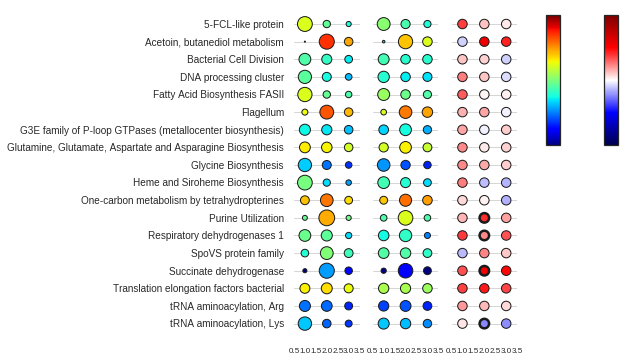

In [309]:
ddff=(co_increase)
ddff=ddff.sort_values(by='Subsystem', ascending=False)
subcategory=np.arange(0,len(ddff),1)

hf_x = np.full(len(ddff), 1)
co_x = np.full(len(ddff), 2)
h2_x = np.full(len(ddff), 3)

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(4,6), sharey=True)
sns.set_style('white')
sns.despine( bottom=True, left=True)
ax1.tick_params(axis='y', pad=10)

cm = plt.cm.get_cmap('jet')
sc = ax1.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_ribo_hf)*3,c=np.log2(ddff.percent_ribo_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_ribo_co)*3,c=np.log2(ddff.percent_ribo_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax1.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_ribo_h2c)*3,c=np.log2(ddff.percent_ribo_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax1.set_yticks(np.arange(0,len(ddff),1))
ax1.set_yticklabels(ddff.Subsystem, fontsize=10)
ax1.set_ylim(-1,len(ddff))
ax1.grid()
ax1.xaxis.grid()
ax1.tick_params(axis='y', pad=10)


cm = plt.cm.get_cmap('jet')
sc = ax2.scatter(x=hf_x, y=subcategory, \
                s=(ddff.percent_rna_hf)*3,c=np.log2(ddff.percent_rna_hf_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=co_x, y=subcategory, \
                s=(ddff.percent_rna_co)*3,c=np.log2(ddff.percent_rna_co_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))

sc = ax2.scatter(x=h2_x, y=subcategory, \
                s=(ddff.percent_rna_h2c)*3,c=np.log2(ddff.percent_rna_h2c_col),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(0.004), vmax=np.log2(40))
ax2.set_yticks(np.arange(0,len(ddff),1))
ax2.set_ylim(-1,len(ddff))
ax2.grid()
ax2.xaxis.grid()
position=fig.add_axes([1,.58 ,0.05,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
cbar.ax.set_yticklabels([])

cm = plt.cm.get_cmap('seismic')
vmaxx=15
vminn=0.05
sc = ax3.scatter(x=hf_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_hf_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax= np.log2(vmaxx))

sc = ax3.scatter(x=co_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_co_subsystem),cmap=cm,\
                linewidth=co_edges,alpha=1, vmin=np.log2(vminn), vmax= np.log2(vmaxx))

sc = ax3.scatter(x=h2_x, y=subcategory, \
                s=90,c=np.log2(ddff.te_h2c_subsystem),cmap=cm,\
                linewidth=1,alpha=1, vmin=np.log2(vminn), vmax=np.log2(vmaxx))
ax3.set_yticks(np.arange(0,len(ddff),1))
ax3.set_ylim(-1,len(ddff))
ax3.grid()
ax3.xaxis.grid()
position=fig.add_axes([1.2,.58 ,0.05,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
cbar.ax.set_yticklabels([])
#plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RAST_subsystem_significant_TE_autotrophic.pdf', bbox_inches='tight')

## plotting the whole subsystems as bars

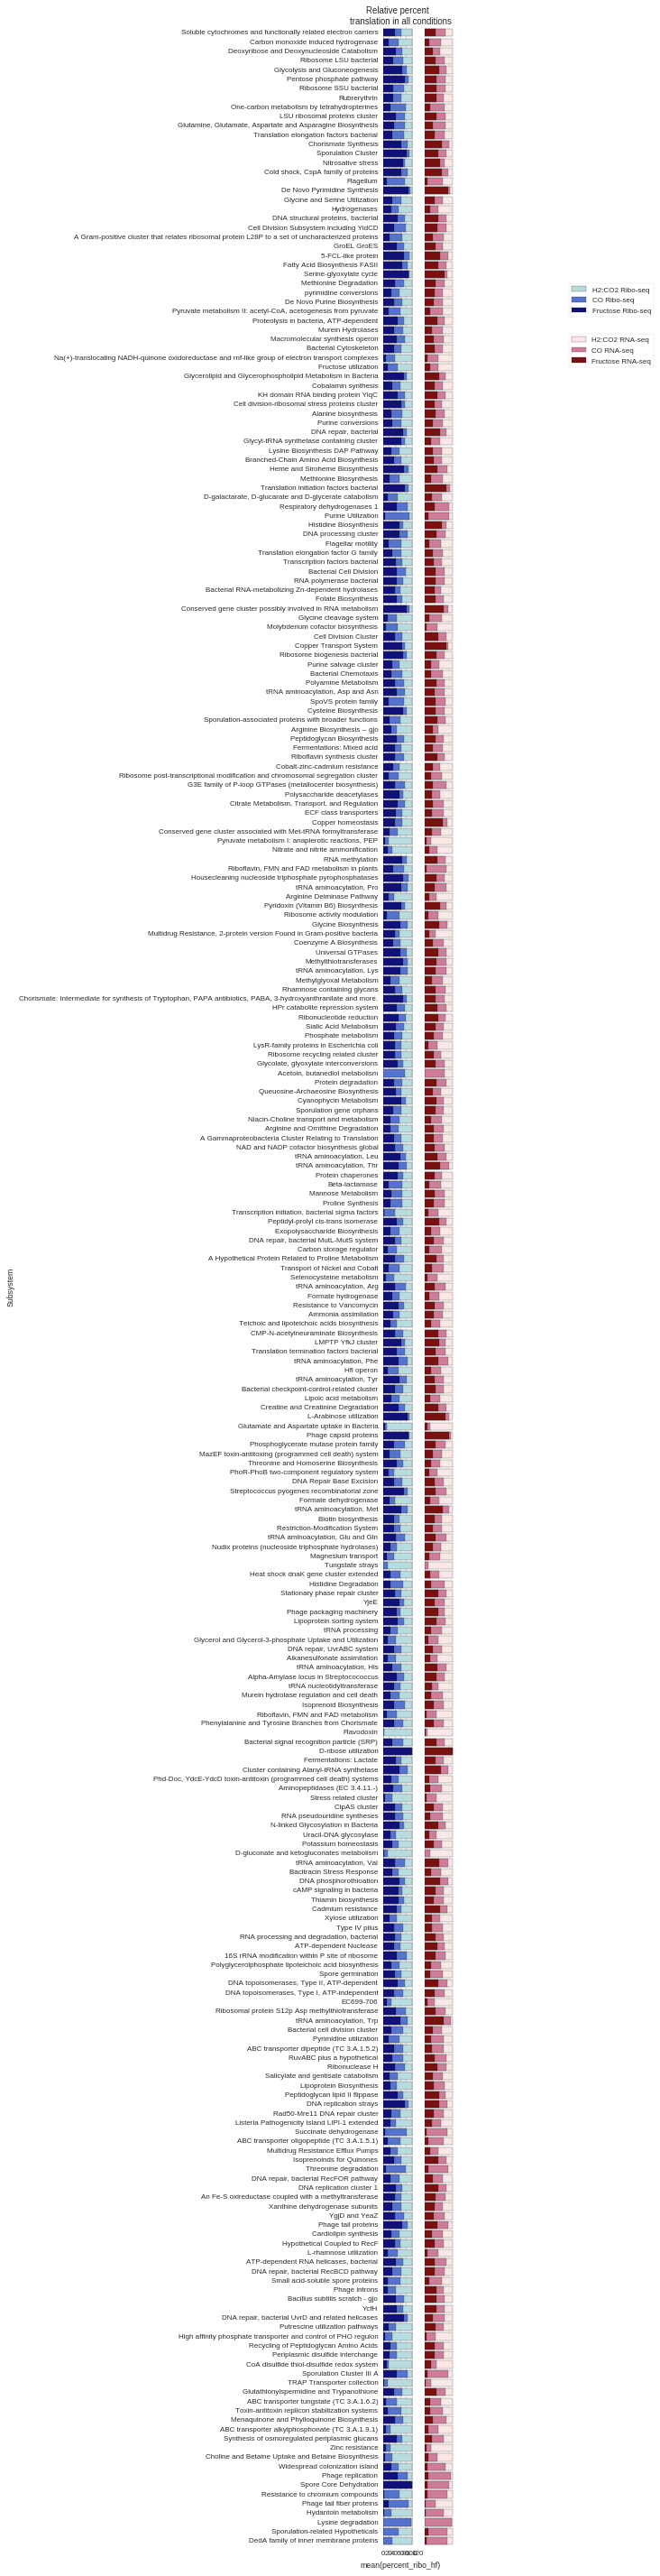

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_context('paper')
f, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(1.5, 50))
sns.set_color_codes("bright")

sns.barplot(x="ribo_sum_row", y="Subsystem", data=category_accross_rows,label="H2:CO2 Ribo-seq", color="powderblue", ax=ax1)
sns.barplot(x="co_hf_ribo_row", y="Subsystem", data=category_accross_rows, label="CO Ribo-seq", color="royalblue", ax=ax1)
sns.barplot(x="percent_ribo_hf", y="Subsystem", data=category_accross_rows, label="Fructose Ribo-seq", color="darkblue", ax=ax1)

sns.barplot(x="rna_sum_row", y="Subsystem", data=category_accross_rows,label="H2:CO2 RNA-seq", color="mistyrose", ax=ax2)
sns.barplot(x="co_hf_rna_row", y="Subsystem", data=category_accross_rows, label="CO RNA-seq", color="palevioletred", ax=ax2)
sns.barplot(x="percent_rna_hf", y="Subsystem", data=category_accross_rows, label="Fructose RNA-seq", color="darkred", ax=ax2)
ax2.set_axis_off()
ax1.set_title("Relative percent  \ntranslation in all conditions", )
sns.despine(left=True, bottom=True, ax =ax1)
ax1.legend(ncol=1, bbox_to_anchor=(8, 0.9), frameon=True,)
ax2.legend(ncol=1, bbox_to_anchor=(6.8, 0.88), frameon=True)
plt.show()

## Extracting key genes/pathways from interesting subsystems

In [129]:
kegg=pd.read_excel('/home/m/Dropbox/Clostridium_paper/Kegg/clju_path_annotation.xls')

In [151]:
Hetero_increase_s = Hetero_increase[['Subsystem']]
Auto_increase_s = Auto_increase[['Subsystem']]

In [152]:
Hetero_back_mapping = pd.merge(df,Hetero_increase_s, left_on='Subsystem', right_on='Subsystem')
Auto_back_mappint = pd.merge(df, Auto_increase_s, left_on='Subsystem', right_on='Subsystem')

## merging with KEGG

In [153]:
Hetero_back_mapping2 = pd.merge(Hetero_back_mapping, kegg, on='gene_id')
Auto_back_mappint2 = pd.merge(Auto_back_mappint, kegg, on='gene_id')

In [154]:
Hetero_back_mapping2.to_excel('/home/m/Dropbox/Clostridium_paper/Heterotrophic_Autotrophic_diff_translation_rast/Hetero_diff_trans_genes_kegg.xls')
Auto_back_mappint2.to_excel('/home/m/Dropbox/Clostridium_paper/Heterotrophic_Autotrophic_diff_translation_rast/Auto_diff_trans_genes_kegg.xls')

In [161]:
Hetero_back_mapping2.columns


Index([           u'gene_id',      u'old_gene_id_x',    u'av_ribo_rpkm_co',
          u'av_ribo_rpkm_hf',   u'av_ribo_rpkm_h2c',     u'av_rna_rpkm_co',
           u'av_rna_rpkm_hf',    u'av_rna_rpkm_h2c',         u'Unnamed: 0',
               u'Feature ID',              u'locus',         u'Category_x',
              u'Subcategory',          u'Subsystem',               u'Role',
               u'Organism A',            u'kegg_id', u'original_kegg_desc',
                      u'cat',               u'kegg',            u'pathway',
              u'subcategory',         u'Category_y',   u'kegg_pathway_idx',
                    u'index',      u'old_gene_id_y',              u'start',
                     u'stop',            u'product'],
      dtype='object')

In [165]:
kegg.columns

Index([u'gene_id', u'kegg_id', u'original_kegg_desc', u'cat', u'kegg',
       u'pathway', u'subcategory', u'Category', u'kegg_pathway_idx', u'index',
       u'old_gene_id', u'start', u'stop', u'product'],
      dtype='object')

In [180]:
Hetero_back_mapping2.groupby(['Subcategory','pathway','Role','gene_id' ]).sum().to_excel('/home/m/Dropbox/Clostridium_paper/Heterotrophic_Autotrophic_diff_translation_rast/hetero_diff_trans_genes_kegg_groupby.xls')

In [181]:
Auto_back_mappint2.groupby(['Subcategory','pathway','Role','gene_id' ]).sum().to_excel('/home/m/Dropbox/Clostridium_paper/Heterotrophic_Autotrophic_diff_translation_rast/Auto_diff_trans_genes_kegg_groupby.xls')

In [327]:
# This is just to save kegg annotated genes with three experiments expression
my_df = pd.read_excel('/home/m/Dropbox/Clostridium_paper/CLJU_omics_df.xls')
save = pd.merge(kegg,my_df, on='gene_id')
save.to_excel('/home/m/Dropbox/Clostridium_paper/Kegg/kegg_merged_with_all_omics_data.xls')

In [ ]:

K00058 
K00134 
K00615 
K00850 
K00873 
K00927 
K00948 
K01689 
K01754 
K01803 
K15633 
